

# BFS:MeerKAT Aggregation

This notebook is for aggregating the results of the Bursts from Space: MeerKAT.

In [1]:
from panoptes_client import Panoptes, Project, SubjectSet, Subject, Workflow
Panoptes.connect(username='alex-andersson', password='')


In [75]:
%matplotlib inline 
#notebook
import pandas as pd
import seaborn as sns

#from panoptes_aggregation.csv_utils import unjson_dataframe
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

import sys
import urllib.request
import ast
import glob

import astropy.units as u
from astropy.coordinates import SkyCoord
#sys.path.append("/Users/andersson/Documents/Zoo/data-digging/scripts_GeneralPython")

In [2]:
#cannibalise some sections from the 'data-digging repository'
#from 00
project_name = "bursts-from-space-meerkat"
classification_file = project_name + "-classifications.csv"
classifications_all = pd.read_csv('/Users/andersson/Documents/Zoo/ProjectData/'+classification_file)
n_class = len(classifications_all)
print("File %s read with %d rows." % (classification_file, n_class))
users_all = classifications_all['user_name'].unique()
n_users = len(users_all)

# if the classification is from a classifier who isn't signed in, the user_name field has "not-logged-in-[user_ip]"
is_unreg = np.array([q.startswith("not-logged-in") for q in users_all])
is_reg   = np.invert(is_unreg)

n_unreg = sum(is_unreg)
n_reg   = sum(is_reg)

print("%d classifications from %d classifiers, of which %d (%.0f percent) were signed-in and %d (%.0f percent) were not signed in.\n" % (n_class, n_users, n_reg, (float(n_reg)/float(n_users)*100.), n_unreg, (float(n_unreg)/float(n_users)*100.)))

print("Average classifications per user: %.1f" % (float(n_class)/float(n_users)))



File bursts-from-space-meerkat-classifications.csv read with 90486 rows.
90486 classifications from 1144 classifiers, of which 595 (52 percent) were signed-in and 549 (48 percent) were not signed in.

Average classifications per user: 79.1


/Users/andersson/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (8,9) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
## from 01

from basic_classification_processing import basic_stats_processing

basic_stats_processing('/Users/andersson/Documents/Zoo/ProjectData/' + classification_file,
                        workflow_id=19109, workflow_version=16.84, 
                       remove_duplicates=True, 
                       outfile_csv='/Users/andersson/Documents/Zoo/ProjectData/basic_proccess_clean_classified.csv', 
                       keep_allcols=True, verbose=True)

Computing project stats using:
   infile: /Users/andersson/Documents/Zoo/ProjectData/bursts-from-space-meerkat-classifications.csv
Reading classifications from /Users/andersson/Documents/Zoo/ProjectData/bursts-from-space-meerkat-classifications.csv
Considering only workflow id 19109
Considering only major workflow version 16
Considering all classifications in workflow_versions:
[16.8  16.84]
Retaining all non-live classifications in analysis.
Found 29 duplicate classifications (0.03 percent of total).
Duplicates removed from analysis (29 unique user-subject-workflow groups).

Overall:

89012 classifications of 8896 subjects by 1038 classifiers,
559 logged in and 479 not logged in, from 1416 unique IP addresses.
85634 classifications were from logged-in users, 3378 from not-logged-in users.

That's 10.01 classifications per subject on average (median = 10.0).
The most classified subject has 13 classifications; the least-classified subject has 1.

Median number of classifications per use

1038 8901.2


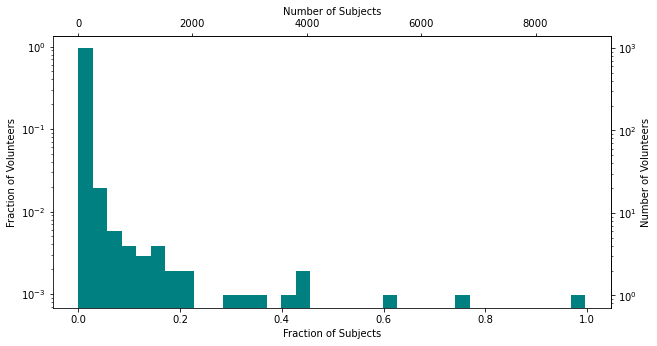

483 2091.8


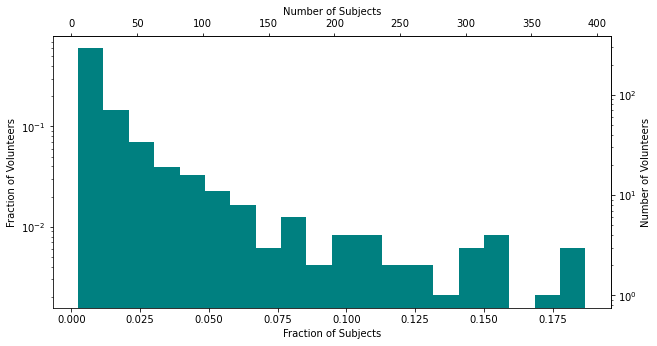

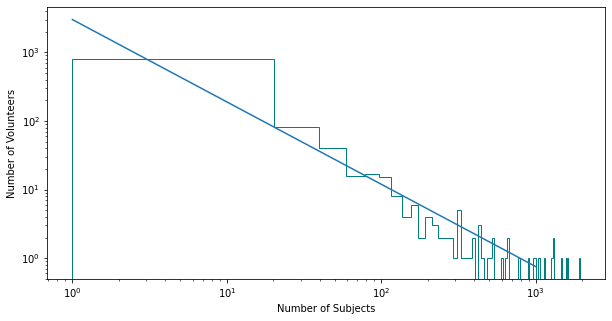

In [5]:
#classifications per user:
#%matplotlib notebook
CPUdata = pd.read_csv('/Users/andersson/Documents/Zoo/ProjectData/' + 'bursts-from-space-meerkat-classifications_nclass_byuser_ranked.csv')
n = len(CPUdata)
nsub = 0.1*CPUdata['n_class'].sum()
print(n,nsub)
weights = np.ones(n) / n
fig = plt.figure(figsize=(10,5))
ax = plt.gca()
ax.hist(CPUdata.n_class/nsub, histtype='bar', weights = weights, bins = 35 ,color='teal')
plt.ylabel('Fraction of Volunteers')
plt.xlabel('Fraction of Subjects')
ax.set_yscale('log')
secax = ax.secondary_xaxis('top', functions=(lambda x:x*nsub, lambda x:x/nsub))
secax.set_xlabel('Number of Subjects')
thax = ax.secondary_yaxis('right', functions=(lambda x: x*n, lambda x:x/n))
thax.set_ylabel('Number of Volunteers')
#thax.set_yscale('linear')
#plt.savefig('Volunteer Dist.png', bbox_inches = 'tight', dpi=1000, transparent=False, facecolor='white')
plt.show()

# a plot of the 'bulk' of the distributions
bulk = CPUdata[(CPUdata['n_class'] > 4) & (CPUdata['n_class'] < 400)]
nsub = bulk['n_class'].sum()*0.1
n = len(bulk)
print(n,nsub)
weights = np.ones(n) / n
fig = plt.figure(figsize=(10,5))
ax = plt.gca()
ax.hist(bulk.n_class/nsub, histtype='bar', weights = weights, bins = 20 ,color='teal')
plt.ylabel('Fraction of Volunteers')
plt.xlabel('Fraction of Subjects')
ax.set_yscale('log')
secax = ax.secondary_xaxis('top', functions=(lambda x:x*nsub, lambda x:x/nsub))
secax.set_xlabel('Number of Subjects')
thax = ax.secondary_yaxis('right', functions=(lambda x: x*n, lambda x:x/n))
thax.set_ylabel('Number of Volunteers')
#thax.set_yscale('linear')


#funnny to see the power law distribution!
fig = plt.figure(figsize=(10,5))
ax = plt.gca()
ax.hist(CPUdata.n_class[10:], histtype='step',  bins = 100 ,color='teal')
x=np.linspace(1,1000)
y=3000*x**-1.2
ax.plot(x,y)
ax.set(yscale='log',xscale='log', xlabel= 'Number of Subjects', ylabel = 'Number of Volunteers')
plt.show()

In [6]:
CPUdata.describe()


,n_class,user_id
count,1038.000000,5.590000e+02
mean,85.753372,1.906011e+06
std,491.346393,7.488151e+05
min,1.000000,3.500000e+01
25%,2.000000,1.674539e+06
50%,4.500000,2.314255e+06
75%,19.000000,2.412088e+06
max,8872.000000,2.438377e+06


In [52]:
# read-in and calculating simple vote fractions.
data = pd.read_csv('ProjectData/question_reducer_reductions.csv')
data = data.fillna(0)
subjectdata = pd.read_csv('ProjectData/bursts-from-space-meerkat-subjects.csv')
subjectdata.fillna(0)
print(len(data), 'sources classified')



data['Sum'] = (data['data.transient-variable']+data['data.stable']+data['data.extended-blob']
              +data['data.unsure']+data['data.artefact']).fillna(0)
data['transFrac'] = data['data.transient-variable'] / data.Sum
data['stableFrac'] = data['data.stable'] / data.Sum
data['extendFrac'] = data['data.extended-blob'] / data.Sum
data['unsureFrac'] = data['data.unsure']/data.Sum
data['arteFrac']  =  data['data.artefact']/data.Sum
data['T+U'] = (data['data.unsure'] + data['data.transient-variable'])/data.Sum

# this is a crucial step. it merges the reduced classifications with the original subject data
# allowing us to instantly check the data and metadata (including downloading files from online) for a given subject
data = pd.merge(data, subjectdata, how='inner', on=['subject_id'])
data = pd.concat([data,pd.DataFrame([ast.literal_eval(row) for row in data['metadata']])],axis=1)
data = pd.concat([data,pd.DataFrame([ast.literal_eval(row) for row in data['locations']])],axis=1)
data = data.rename(columns={"0": "LCurl", "1": "Imageurl"})

data = pd.concat([
    data['LC'].str.split('_',expand=True)[3].apply(lambda x: 'GX339'if x == 'anderssontrapLC.png' else x).str.split('Tr',expand=True)[0]
                  , data],axis=1)
data = data.rename(columns={0:'Field'})
print(len(data), 'sources classified')

#here is the slowest (LONG) step in the process - search online for the Subjects with that id
'''
SubjectList = [Subject.find(val) for val in data['subject_id']]
print('Finished finding subjects.')


plt.figure(figsize=(8,6))
plt.hist([data.stableFrac,data.extendFrac,data.transFrac, data.unsureFrac, data.arteFrac], 
         stacked=True, label = ['Stable','Extended','Trans./Variable Cand.', 'Unsure', 'Artefact'], 
         color=['grey','purple','gold', 'Teal', 'Red'])
plt.xlabel('Vote Fraction')
plt.legend()
plt.show()
'''

#plt.figure(figsize=(8,6))
#plt.hist(data.transFrac, 
#         label = 'Trans./Variable', 
#         color='purple')
#plt.xlabel('Vote Fraction')
#plt.legend()
#plt.show()
#
#plt.figure(figsize=(8,6))
#plt.hist(data.unsureFrac, 
#         label = 'Unsure', 
#         color='orange')
#plt.xlabel('Vote Fraction')
#plt.legend()
#plt.show()

#print(data.info())
pd.set_option('display.max_columns', 1000)

8874 sources classified
8874 sources classified


In [53]:
sdl = []
for i, file in enumerate(glob.iglob('/Users/andersson/Documents/Zoo/TraPData/TraPSourceStats/*', recursive=True)):
    f = file.split('/')[-1].split('Source')[0]
    sourcedata = pd.read_csv(file)
    sourcedata['Field'] = f
    sdl.append(sourcedata)

SourceData = pd.concat(sdl)  
data = data.astype({'runcat':'int64'})
data = data.astype({'medianFlux(mJy)':'float64'})

data = pd.merge(data, SourceData, how='left', on=['Field','runcat'])
data

,Field,subject_id,workflow_id_x,task,reducer,data.stable,data.unsure,data.extended-blob,data.aggregation_version,data.transient-variable,data.artefact,Sum,transFrac,stableFrac,extendFrac,unsureFrac,arteFrac,T+U,project_id,workflow_id_y,subject_set_id,metadata,locations,classifications_count,retired_at,retirement_reason,created_at,updated_at,LC,RA_x,Dec_x,Image,runcat,date_obs,medianFlux(mJy),LCurl,Imageurl,eta,V,maxFlux,medFlux,avgFlux,coord_datapoints,newSource,RA_y,RA_err,Dec_y,Dec_err
0,GX339,70785283,19109,T0,question_reducer,6.0,1.0,2.0,3.6.0,0.0,0.0,9.0,0.0,0.666667,0.222222,0.111111,0.000000,0.111111,15976,19109.0,100043,"{""LC"":""10636_ra256.621_dec-48.149_anderssontra...","{""0"":""https://panoptes-uploads.zooniverse.org/...",10,2022-01-14 18:11:54 UTC,classification_count,2021-12-03 14:10:00 UTC,2021-12-03 14:10:00 UTC,10636_ra256.621_dec-48.149_anderssontrapLC.png,256.621117139368,-48.1489166733255,10636_ra256.621_dec-48.149_anderssontrapImage.png,10636,2021-03-08T00:00:00.000,0.263177,https://panoptes-uploads.zooniverse.org/subjec...,https://panoptes-uploads.zooniverse.org/subjec...,0.568889,0.175555,0.000402,0.000263,0.000263,18,N,256.621250,0.000329,-48.148688,0.000329
1,GX339,70785284,19109,T0,question_reducer,8.0,1.0,0.0,3.6.0,1.0,0.0,10.0,0.1,0.800000,0.000000,0.100000,0.000000,0.200000,15976,19109.0,100043,"{""LC"":""10628_ra256.555_dec-48.825_anderssontra...","{""0"":""https://panoptes-uploads.zooniverse.org/...",10,2022-02-06 18:47:00 UTC,classification_count,2021-12-03 14:10:00 UTC,2021-12-03 14:10:00 UTC,10628_ra256.555_dec-48.825_anderssontrapLC.png,256.555341864294,-48.824875405248605,10628_ra256.555_dec-48.825_anderssontrapImage.png,10628,2018-04-14T00:00:00.000,0.931652,https://panoptes-uploads.zooniverse.org/subjec...,https://panoptes-uploads.zooniverse.org/subjec...,1.097027,0.070521,0.001141,0.000932,0.000935,166,N,256.555326,0.000108,-48.824949,0.000108
2,GX339,70785285,19109,T0,question_reducer,8.0,2.0,0.0,3.6.0,0.0,0.0,10.0,0.0,0.800000,0.000000,0.200000,0.000000,0.200000,15976,19109.0,100043,"{""LC"":""10132_ra254.733_dec-48.563_anderssontra...","{""0"":""https://panoptes-uploads.zooniverse.org/...",10,2022-02-08 14:47:10 UTC,classification_count,2021-12-03 14:10:00 UTC,2021-12-03 14:10:00 UTC,10132_ra254.733_dec-48.563_anderssontrapLC.png,254.732728851156,-48.563562219775704,10132_ra254.733_dec-48.563_anderssontrapImage.png,10132,2018-04-14T00:00:00.000,0.232827,https://panoptes-uploads.zooniverse.org/subjec...,https://panoptes-uploads.zooniverse.org/subjec...,0.472002,0.189872,0.000361,0.000233,0.000237,5,N,254.732397,0.000625,-48.563505,0.000625
3,GX339,70785286,19109,T0,question_reducer,5.0,0.0,3.0,3.6.0,0.0,1.0,9.0,0.0,0.555556,0.333333,0.000000,0.111111,0.000000,15976,19109.0,100043,"{""LC"":""10529_ra256.135_dec-48.598_anderssontra...","{""0"":""https://panoptes-uploads.zooniverse.org/...",10,2022-02-14 02:32:14 UTC,classification_count,2021-12-03 14:10:00 UTC,2021-12-03 14:10:00 UTC,10529_ra256.135_dec-48.598_anderssontrapLC.png,256.135396262086,-48.5982446578128,10529_ra256.135_dec-48.598_anderssontrapImage.png,10529,2018-04-14T00:00:00.000,10.678822,https://panoptes-uploads.zooniverse.org/subjec...,https://panoptes-uploads.zooniverse.org/subjec...,54.601966,0.061160,0.012574,0.010679,0.010670,166,N,256.135428,0.000108,-48.598259,0.000108
4,GX339,70785287,19109,T0,question_reducer,5.0,2.0,2.0,3.6.0,0.0,0.0,9.0,0.0,0.555556,0.222222,0.222222,0.000000,0.222222,15976,19109.0,100043,"{""LC"":""10654_ra256.796_dec-48.938_anderssontra...","{""0"":""https://panoptes-uploads.zooniverse.org/...",10,2022-01-26 22:51:46 UTC,classification_count,2021-12-03 14:10:00 UTC,2021-12-03 14:10:00 UTC,10654_ra256.796_dec-48.938_anderssontrapLC.png,256.79559268765803,-48.938215956063296,10654_ra256.796_dec-48.938_anderssontrapImage.png,10654,2018-04-14T00:00:00.000,0.215131,https://panoptes-uploads.zooniverse.org/subjec...,https://panoptes-uploads.zooniverse.org/subjec...,0.303607,0.158776,0.000310,0.00021

In [54]:
# here is where we combine expert labels to the citSci votes to produce our final variable sample. To do this we took
#all sources above a transFrac of 0.4, eyeballed them and wrote booleans, with notes
T=0.4
MajorTrans = data[data['transFrac']>= T]
print(len(MajorTrans))
ELs = pd.read_csv('0.4TExpertLabels.csv')
ELT = pd.merge(MajorTrans, ELs, how='inner', on=['runcat','Field'])

#defining expertly labelled false positives and trues
#ELFPs = ELT[ELT['t/v']==0]
#ELTs = ELT[ELT['t/v']==1]
#print(len(ELFPs),len(ELTs))

data = pd.merge(data,ELs, how='left',on=['runcat','Field']).fillna(value=0)


381


In [97]:
#here we define some functions for light curve statistics:
def madulation_parameter(data):
    '''
    Use the median and mad to make a modulation-type parameter.

    Args:
    data (array): the 1D array
                  of data that you
                  want to find the
                  MAD parameter of
    Returns:
    (madvalue, madlocation)
    The value of the MAD parameter
    and the index of the epoch
    of the MAD parameter
    '''
    me = np.nanmedian(data)
    ma = np.nanmedian(np.absolute(data-np.nanmedian(data)))

    
    data_ = np.copy(data)
    
    shifted_data = np.abs(data_ - me)
    divided_by_mad = shifted_data/ma
    
    try:
        madvalue = np.nanmax(divided_by_mad)
        madlocation = np.nanargmax(divided_by_mad)
    except ValueError:
        madvalue = np.nan
        madlocation = np.nan
    
    return madvalue, madlocation

def chi2_parameter(data, uncertainties):
    '''
    Calculate the chi2 variability parameter for a set of points.
    
    A description of the variability parameter
    can be found here:
    https://tkp.readthedocs.io/en/r3.0/devref/
    database/schema.html#appendices
    
    Args:
    data (array): a 1D row array of data points
    uncertainties (array): the 1D array of uncertainties
                           that corresponds to the data array
    
    Returns:
    A float that is the value of the variability
    parameter for the data array
    '''
    weights = 1./(uncertainties**2.)
    
    if len(data[~np.isnan(data)]) < 2:
        p1 = 1
    else:
        p1 = len(data[~np.isnan(data)])/(len(data[~np.isnan(data)])-1.)
    p2 = np.nanmean(weights*(data**2.))
    p3 = ((np.nanmean(weights*data))**2.)/(np.nanmean(weights))
    
    return p1 * (p2 - p3)
def modulation_parameter(data):
    '''
    Calculate the modulation parameter for a set of points.
    
    A description of the modulation parameter
    can be found here:
    https://tkp.readthedocs.io/en/r3.0/devref/
    database/schema.html#appendices
    
    Args:
    data (array): a 1D row array of data points
    
    Returns:
    A float that is the value of the modulation
    parameter for the data array
    '''

    p1 = 1./np.nanmean(data)
    if len(data[~np.isnan(data)]) <2:
        p2 = 1
    else:
        p2 = len(data[~np.isnan(data)])/(len(data[~np.isnan(data)])-1)
    p3 = np.nanmean(data**2.) - (np.nanmean(data))**2.
    
    return p1 * np.sqrt(p2*p3)

phaseCentres = {'GX339': SkyCoord(255.70566666667, -48.789666666667,unit=(u.deg, u.deg)),
                'GRS1915': SkyCoord(288.798125, 10.9416111111111,unit=(u.deg, u.deg)),
                'J1848G': SkyCoord(282.2075416667, -1.49166666666667,unit=(u.deg, u.deg)),
                'MAXIJ1803': SkyCoord(270.761625, -29.8263055555556,unit=(u.deg, u.deg)),
                'SAXJ1808': SkyCoord(272.11475, -36.9789722222222,unit=(u.deg, u.deg)),
                '4U1543': SkyCoord(236.7845000000, -47.67361111111,unit=(u.deg, u.deg)),
                'EXO1846': SkyCoord(282.3207916666666, -3.06536111111111,unit=(u.deg, u.deg)),
                'H1743': SkyCoord(266.565, -32.2335833333333,unit=(u.deg, u.deg)),
                'J1858': SkyCoord(284.6456667, -8.23788888888889,unit=(u.deg, u.deg)),
                'MAXIJ1348': SkyCoord(207.05304166667, -63.27411111111,unit=(u.deg, u.deg)),
                'MAXIJ1820': SkyCoord(275.0914166666666, 7.18533333333333,unit=(u.deg, u.deg))
}
def dist_phase_centre(field,RA,Dec,PhaseCentres):
    objCoord = SkyCoord(RA,Dec,unit=(u.deg, u.deg))
    pc = phaseCentres[field]
    return pc.separation(objCoord).arcminute


KnownVs = {'GX339':[10165,10181,10204,10224,10233,10235,10239,10209,10280,10293,
                    10266,10264,10317,10736,10334,10484,10486,10449,
                    10496,10559,10609,10657,10663],
           'GRS1915': [3169], 'J1848G': [94, 229,266],
          'MAXIJ1803':[309],'SAXJ1808':[601], '4U1543':[853, 329],
          'EXO1846':[282, 89],'H1743':[2224,2138,2139,1932],
          'J1858':[2323], 'MAXIJ1348':[183,431,504],'MAXIJ1820':[229, 583]}

def KnownLabels(EL,KnownVs,field,runcat):
    if runcat in KnownVs[field]:
        return 1
    else:
        return 0
    
def FractionalVariability(data):
    return (max(data)-min(data))/np.median(data)
    


In [98]:
#this cell takes a few mins to run: it accesses all light curves, adds some stats calculated from each to the
#data df, as well as creating a Series object where each row is a light curve df, with appended columns fulll of
#scalar values from the original data df.
LCList = []
import time
start_time = time.time()
for i, file in enumerate(glob.iglob('/Users/andersson/Documents/Zoo/TraPData/AllLightCurves/*/*',recursive=True)):
    LC = pd.read_csv(file)
    f = file.split('/')[-1].split('_')[-2].rstrip('TraPDB')
    if 'dec' in f:
        f = 'GX339'
    runcat = int(file.split('/')[-1].split('_')[0])
    #LC['Field'] = f
    #LC['runcat'] = runcat
    #LC = LC.astype({'runcat':'int64'})
    
    idx = data[(data['Field']==f )& (data['runcat']==runcat)].index#['LCdf'] = LC
    #here we are assigning new columns to data, one row at a time... slow...
    data.loc[idx,'N_datapoints'] = len(LC)
    data.loc[idx,'MedianFlux'] = np.nanmedian(LC['f_int'])
    data.loc[idx,'MeanFlux'] = np.nanmean(LC['f_int'])
    data.loc[idx,'MaximumFlux'] = np.nanmax(LC['f_int'])
    data.loc[idx,'MinimumFlux'] = np.nanmin(LC['f_int'])
    data.loc[idx,'MAD'] = madulation_parameter(LC['f_int'])[0]
    data.loc[idx,'eta2'] = chi2_parameter(LC['f_int'],LC['f_int_err'])
    data.loc[idx,'V2'] = modulation_parameter(LC['f_int'])
    data.loc[idx,'pc_dist(arcmin)'] = dist_phase_centre(f, data.loc[idx,'RA_y'], data.loc[idx,'Dec_y'],phaseCentres)
    data.loc[idx,'Known?'] = KnownLabels(data.loc[idx,'t/v'].values[0],KnownVs,f,runcat)
    data.loc[idx,'FracVar'] =  FractionalVariability(LC['f_int'])
    #print(data.loc[idx])
    # here we are then adding the scalar values as columns to each LCd.f.... also slow
    #for column in data.columns:
    #    LC[column] = data.loc[idx,column].values[0]
    
    #if i>1:
    #   break
    LCList.append(LC)

LCList = pd.Series(LCList)
print("--- %s seconds ---" % (time.time() - start_time))



<ipython-input-97-c41feb5c2c31>:24: RuntimeWarning: invalid value encountered in true_divide
  divided_by_mad = shifted_data/ma
<ipython-input-97-c41feb5c2c31>:27: RuntimeWarning: All-NaN slice encountered
  madvalue = np.nanmax(divided_by_mad)
<ipython-input-97-c41feb5c2c31>:24: RuntimeWarning: invalid value encountered in true_divide
  divided_by_mad = shifted_data/ma
<ipython-input-97-c41feb5c2c31>:27: RuntimeWarning: All-NaN slice encountered
  madvalue = np.nanmax(divided_by_mad)
<ipython-input-97-c41feb5c2c31>:24: RuntimeWarning: invalid value encountered in true_divide
  divided_by_mad = shifted_data/ma
<ipython-input-97-c41feb5c2c31>:27: RuntimeWarning: All-NaN slice encountered
  madvalue = np.nanmax(divided_by_mad)
<ipython-input-97-c41feb5c2c31>:24: RuntimeWarning: invalid value encountered in true_divide
  divided_by_mad = shifted_data/ma
<ipython-input-97-c41feb5c2c31>:27: RuntimeWarning: All-NaN slice encountered
  madvalue = np.nanmax(divided_by_mad)
<ipython-input-97-c4

<ipython-input-97-c41feb5c2c31>:24: RuntimeWarning: invalid value encountered in true_divide
  divided_by_mad = shifted_data/ma
<ipython-input-97-c41feb5c2c31>:27: RuntimeWarning: All-NaN slice encountered
  madvalue = np.nanmax(divided_by_mad)
<ipython-input-97-c41feb5c2c31>:24: RuntimeWarning: invalid value encountered in true_divide
  divided_by_mad = shifted_data/ma
<ipython-input-97-c41feb5c2c31>:27: RuntimeWarning: All-NaN slice encountered
  madvalue = np.nanmax(divided_by_mad)
<ipython-input-97-c41feb5c2c31>:24: RuntimeWarning: invalid value encountered in true_divide
  divided_by_mad = shifted_data/ma
<ipython-input-97-c41feb5c2c31>:27: RuntimeWarning: All-NaN slice encountered
  madvalue = np.nanmax(divided_by_mad)
<ipython-input-97-c41feb5c2c31>:24: RuntimeWarning: invalid value encountered in true_divide
  divided_by_mad = shifted_data/ma
<ipython-input-97-c41feb5c2c31>:27: RuntimeWarning: All-NaN slice encountered
  madvalue = np.nanmax(divided_by_mad)
<ipython-input-97-c4

<ipython-input-97-c41feb5c2c31>:24: RuntimeWarning: invalid value encountered in true_divide
  divided_by_mad = shifted_data/ma
<ipython-input-97-c41feb5c2c31>:27: RuntimeWarning: All-NaN slice encountered
  madvalue = np.nanmax(divided_by_mad)
<ipython-input-97-c41feb5c2c31>:24: RuntimeWarning: invalid value encountered in true_divide
  divided_by_mad = shifted_data/ma
<ipython-input-97-c41feb5c2c31>:27: RuntimeWarning: All-NaN slice encountered
  madvalue = np.nanmax(divided_by_mad)
<ipython-input-97-c41feb5c2c31>:24: RuntimeWarning: invalid value encountered in true_divide
  divided_by_mad = shifted_data/ma
<ipython-input-97-c41feb5c2c31>:27: RuntimeWarning: All-NaN slice encountered
  madvalue = np.nanmax(divided_by_mad)
<ipython-input-97-c41feb5c2c31>:24: RuntimeWarning: invalid value encountered in true_divide
  divided_by_mad = shifted_data/ma
<ipython-input-97-c41feb5c2c31>:27: RuntimeWarning: All-NaN slice encountered
  madvalue = np.nanmax(divided_by_mad)
<ipython-input-97-c4

--- 123.12547397613525 seconds ---


In [203]:
#including MeerLICHT data:
MLMags = pd.read_csv('ML_Magnitudes.csv')
MLMags=MLMags.sort_values(by='RA')
data = data.sort_values(by='RA_y')
test = pd.concat([data,MLMags],axis=1)
test

,Field,subject_id,workflow_id_x,task,reducer,data.stable,data.unsure,data.extended-blob,data.aggregation_version,data.transient-variable,data.artefact,Sum,transFrac,stableFrac,extendFrac,unsureFrac,arteFrac,T+U,project_id,workflow_id_y,subject_set_id,metadata,locations,classifications_count,retired_at,retirement_reason,created_at,updated_at,LC,RA_x,Dec_x,Image,runcat,date_obs,medianFlux(mJy),LCurl,Imageurl,eta,V,maxFlux,medFlux,avgFlux,coord_datapoints,newSource,RA_y,RA_err,Dec_y,Dec_err,t/v,Extended?,Notes,N_datapoints,MedianFlux,MeanFlux,MaximumFlux,MinimumFlux,MAD,eta2,V2,pc_dist(arcmin),Known?,FracVar,Unnamed: 0,RA,DEC,Sep(arcsec),mag_q,err_mag_q
0,GX339,70785283,19109,T0,question_reducer,6.0,1.0,2.0,3.6.0,0.0,0.0,9.0,0.0,0.666667,0.222222,0.111111,0.000000,0.111111,15976,19109.0,100043,"{""LC"":""10636_ra256.621_dec-48.149_anderssontrapLC.png"",""RA"":""256.621117139368"",""Dec"":""-48.1489166733255"",""Image"":""10636_ra256.621_dec-48.149_anderssontrapImage.png"",""runcat"":""10636"",""date_obs"":""2021-03-08T00:00:00.000"",""medianFlux(mJy)"":""0.263177287870657""}","{""0"":""https://panoptes-uploads.zooniverse.org/subject_location/cfa4865d-1a92-49ef-8b9e-d5a148199dda.png"",""1"":""https://panoptes-uploads.zooniverse.org/subject_location/760813c9-baef-417c-aac0-2d9deb67359a.png""}",10,2022-01-14 18:11:54 UTC,classification_count,2021-12-03 14:10:00 UTC,2021-12-03 14:10:00 UTC,10636_ra256.621_dec-48.149_anderssontrapLC.png,256.621117139368,-48.1489166733255,10636_ra256.621_dec-48.149_anderssontrapImage.png,10636,2021-03-08T00:00:00.000,0.263177,https://panoptes-uploads.zooniverse.org/subject_location/cfa4865d-1a92-49ef-8b9e-d5a148199dda.png,https://panoptes-uploads.zooniverse.org/subject_location/760813c9-baef-417c-aac0-2d9deb67359a.png,0.568889,0.175555,0.000402,0.000263,0.000263,18,N,256.621250,0.000329,-48.148688,0.000329,0.0,0.0,0,166.0,0.000263,0.000263,0.000402,0.000138,4.640011,0.568889,0.175555,52.968272,0.0,1.002285,0.0,275.531789,7.767851,0.000000,22.129420,99.000000
1,GX339,70785284,19109,T0,question_reducer,8.0,1.0,0.0,3.6.0,1.0,0.0,10.0,0.1,0.800000,0.000000,0.100000,0.000000,0.200000,15976,19109.0,100043,"{""LC"":""10628_ra256.555_dec-48.825_anderssontrapLC.png"",""RA"":""256.555341864294"",""Dec"":""-48.824875405248605"",""Image"":""10628_ra256.555_dec-48.825_anderssontrapImage.png"",""runcat"":""10628"",""date_obs"":""2018-04-14T00:00:00.000"",""medianFlux(mJy)"":""0.9316516414018475""}","{""0"":""https://panoptes-uploads.zooniverse.org/subject_location/50a1f9c3-1fe2-4516-9ce3-951dfe7c4d08.png"",""1"":""https://panoptes-uploads.zooniverse.org/subject_location/9d33f7ed-d9c6-4b90-8bd4-7e344088a260.png""}",10,2022-02-06 18:47:00 UTC,classification_count,2021-12-03 14:10:00 UTC,2021-12-03 14:10:00 UTC,10628_ra256.555_dec-48.825_anderssontrapLC.png,256.555341864294,-48.824875405248605,10628_ra256.555_dec-48.825_anderssontrapImage.png,10628,2018-04-14T00:00:00.000,0.931652,https://panoptes-uploads.zooniverse.org/subject_location/50a1f9c3-1fe2-4516-9ce3-951dfe7c4d08.png,https://panoptes-uploads.zooniverse.org/subject_location/9d33f7ed-d9c6-4b90-8bd4-7e344088a260.png,1.097027,0.070521,0.001141,0.000932,0.000935,166,N,256.555326,0.000108,-48.824949,0.000108,0.0,0.0,0,166.0,0.000932,0.000935,0.001141,0.000621,7.989630,1.097027,0.070521,33.641313,0.0,0.557286,1.0,275.525956,6.549153,0.000000,0.000000,0.000000
2,GX339,70785285,19109,T0,question_reducer,8.0,2.0,0.0,3.6.0,0.0,0.0,10.0,0.0,0.800000,0.000000,0.200000,0.000000,0.200000,15976,19109.0,100043,"{""LC"":""10132_ra254.733_dec-48.563_anderssontrapLC.png"",""RA"":""254.732728851156"",""Dec"":""-48.563562219775704"",""Image"":""10132_ra254.733_dec-48.563_anderssontrapImage.png"",""runcat"":""10132"",""date_obs"":""2018-04-14T00:00:00.000"",""medianFlux(mJy)"":""0.23282696447669948""}","{""0"":""https://panoptes-uploads.zooniverse.org/subject_location/e3b3dc60-d3e5-4d12-a97b-9805b4ed3e86.png"",""1"":""https://panoptes-uploads.zooniverse.org/subject_location/e90b917

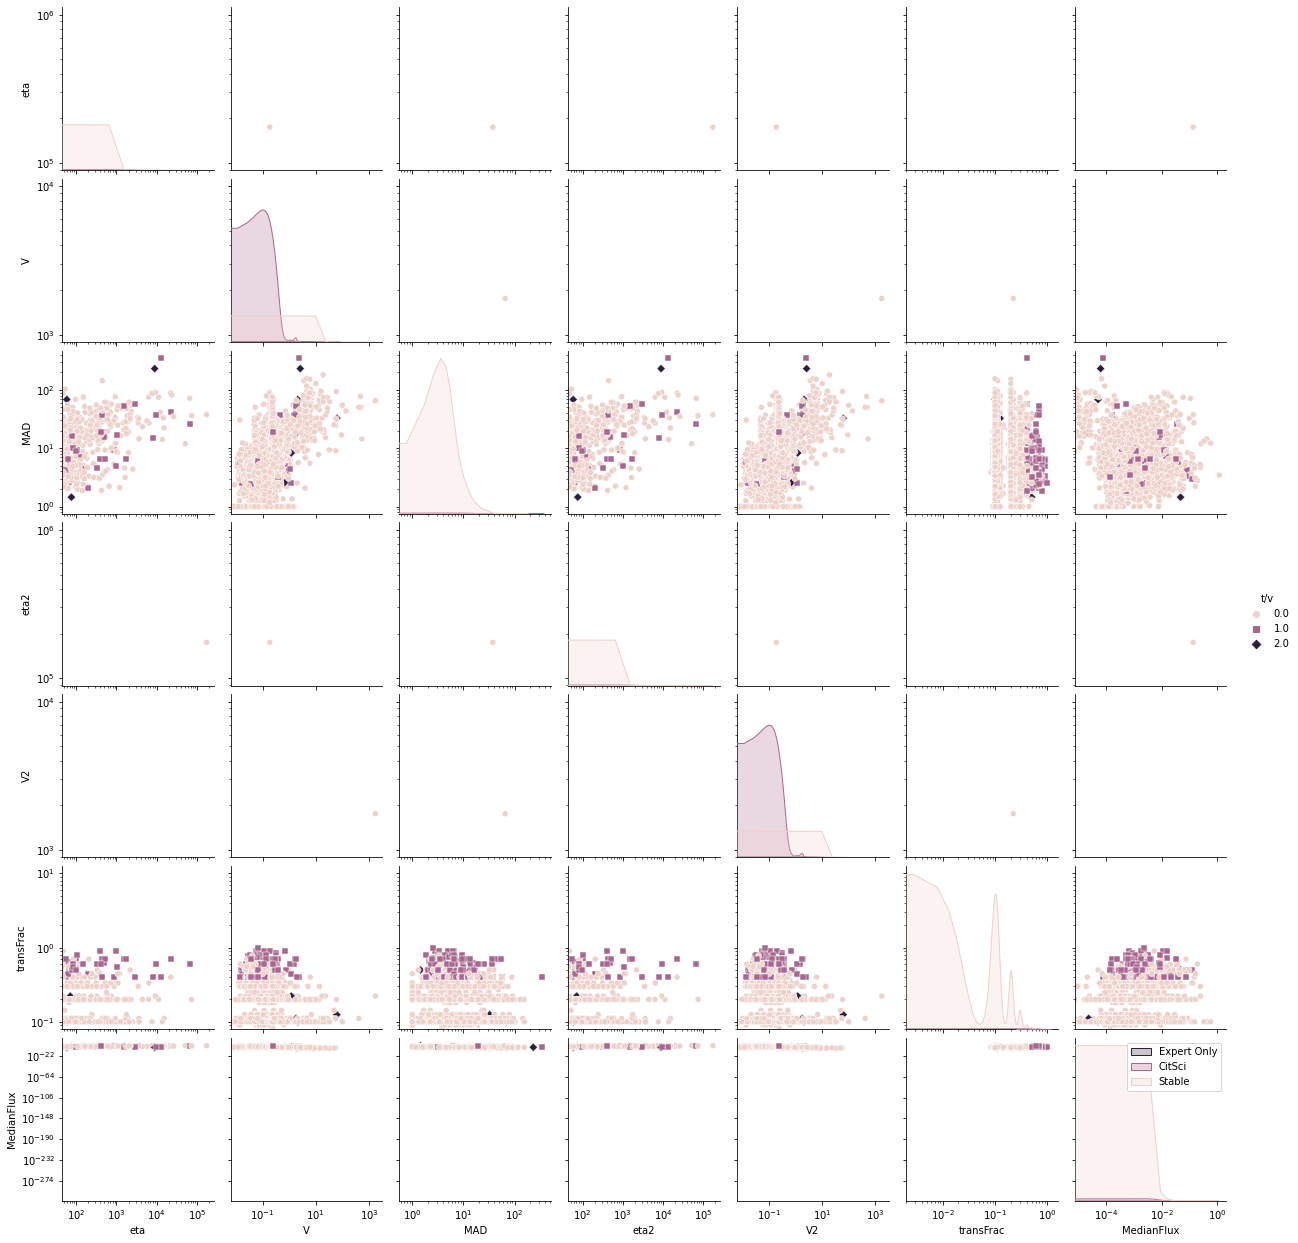

--- 41.75141716003418 seconds ---


In [362]:
start_time = time.time()
columns = ['transFrac','stableFrac','extendFrac','unsureFrac','arteFrac','T+U','eta','V','maxFlux','medFlux','avgFlux'
           ,'N_datapoints','MedianFlux','MeanFlux','MaximumFlux','MinimumFlux'
           ,'MAD','eta2','V2','pc_dist(arcmin)']
columns = ['eta','V','MAD','eta2','V2','transFrac','MedianFlux']
pairs = sns.pairplot(data, hue='t/v', markers=["o", "s", "D"], x_vars=columns,y_vars=columns)
plt.legend(labels=['Expert Only','CitSci','Stable'])
for ax in pairs.axes.flat:
    ax.set(xscale="log",yscale='log'),#ylim=(0.01,1e3), xlim=(0.01,1e3))
plt.show(pairs)
print("--- %s seconds ---" % (time.time() - start_time))

/Users/andersson/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:1182: UserWarning: No contour levels were found within the data range.
  cset = contour_func(


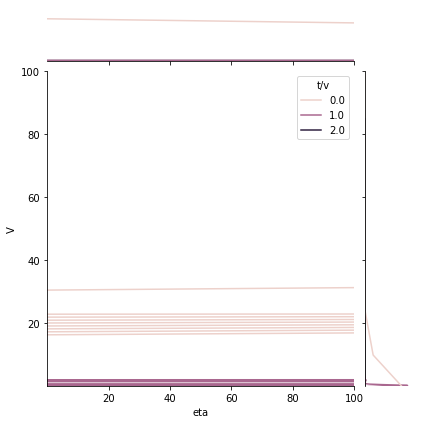

--- 2.7139170169830322 seconds ---


In [373]:
start_time = time.time()
s = sns.jointplot(data=data, x="eta", y="V",hue="t/v", kind="kde",xlim=(1e-2,1e5),ylim=(1e-2,1e2))#, kind="reg")
#s.set(xscale="log",yscale='log')


plt.show(s)
print("--- %s seconds ---" % (time.time() - start_time))

In [99]:
#note that you need a pre-found list of runcat IDs to find them here...
pd.set_option('display.max_columns', 1000)
#FindKnownVariables(data, 'EXO1846', [282, 89]) 
VDF = []


KnownVs = {'GX339':[10165,10181,10204,10224,10233,10235,10239,10209,10280,10293,
                    10266,10264,10317,10736,10334,10484,10486,10449,
                    10496,10559,10609,10657,10663],
           'GRS1915': [3169], 'J1848G': [94, 229,266],
          'MAXIJ1803':[309],'SAXJ1808':[601], '4U1543':[853, 329],
          'EXO1846':[282, 89],'H1743':[2224,2138,2139,1932],
          'J1858':[2323], 'MAXIJ1348':[183,431,504],'MAXIJ1820':[229, 583]}
for field in data['Field'].unique():
    runcats = KnownVs[field]
    VDF.append(FindKnownVariables(data,field,runcats))
    
VDF = pd.concat(VDF)
#grs1915, J1848 and its jets,J1803, 4U1543, both EXO1846&OHMaser, H1743+Force Fit flare star only, J1348& 1 jet, MAXIJ1820, gx339-4
#NOT SAXJ1808, NOT 4U1543's jet, NOT J1858, NOT J1820's jet, NOT J1348's other jet
VDF[(VDF['Field']=='GX339') & (VDF['transFrac']<0.4)]
#11 from gx339 field D:
#VDF.sort_values('V', False)
#note that since first doing this, 3 of the GX339 LTVs were removed. These are TraP runcats 10406,10367,10328
#['2224','2138','2139','1932'])] # these are 'force fit flare star, flare star, flare star, H1743' 
# 100066, ['282', '89'])  # for OH star and EXO1846 
#[100065,100066,  100044,   100043, 100068,100047, 100069,   100070,    100062,        100071,    100064]
#4U1543 ,#EXO1846,#GRS1915,#GX339 ,#H1743,#J1848G ,#J1858,#MAXI J1348 ,#MAXI J1803 ,#MAXI J1820 ,#SAX J1808

# known variables:
# 10736 = GX339-4, GRS1915 = 3169, J1848/G01 = 243, 94, 229, not 266, 
#MAXIJ1803 = 309, SAX J1808 = 601, 4U1543 = 853, 329
# J1858 = 2323, MAXIJ1348 = 183,431,50? MAXI J1820 = 229, 583


,Field,subject_id,workflow_id_x,task,reducer,data.stable,data.unsure,data.extended-blob,data.aggregation_version,data.transient-variable,data.artefact,Sum,transFrac,stableFrac,extendFrac,unsureFrac,arteFrac,T+U,project_id,workflow_id_y,subject_set_id,metadata,locations,classifications_count,retired_at,retirement_reason,created_at,updated_at,LC,RA_x,Dec_x,Image,runcat,date_obs,medianFlux(mJy),LCurl,Imageurl,eta,V,maxFlux,medFlux,avgFlux,coord_datapoints,newSource,RA_y,RA_err,Dec_y,Dec_err,t/v,Extended?,Notes,N_datapoints,MedianFlux,MeanFlux,MaximumFlux,MinimumFlux,MAD,eta2,V2,pc_dist(arcmin),Known?,FracVar
36,GX339,70785319,19109,T0,question_reducer,4.0,1.0,3.0,3.6.0,2.0,0.0,10.0,0.200000,0.400000,0.300000,0.100000,0.000000,0.300000,15976,19109.0,100043,"{""LC"":""10233_ra255.255_dec-48.831_anderssontra...","{""0"":""https://panoptes-uploads.zooniverse.org/...",10,2022-02-06 20:25:52 UTC,classification_count,2021-12-03 14:10:06 UTC,2021-12-03 14:10:06 UTC,10233_ra255.255_dec-48.831_anderssontrapLC.png,255.25470322285,-48.83147024686911,10233_ra255.255_dec-48.831_anderssontrapImage.png,10233,2018-04-14T00:00:00.000,0.276214,https://panoptes-uploads.zooniverse.org/subjec...,https://panoptes-uploads.zooniverse.org/subjec...,0.723391,0.186606,0.000414,0.000276,0.000274,52,N,255.254530,0.000194,-48.831523,0.000194,0.0,0.0,0,166.0,0.000276,0.000274,0.000414,0.000118,3.857357,0.723391,0.186606,18.001774,1.0,1.070326
161,GX339,70785444,19109,T0,question_reducer,4.0,1.0,2.0,3.6.0,2.0,1.0,10.0,0.200000,0.400000,0.200000,0.100000,0.100000,0.300000,15976,19109.0,100043,"{""LC"":""10165_ra254.938_dec-48.784_anderssontra...","{""0"":""https://panoptes-uploads.zooniverse.org/...",10,2022-02-19 19:51:40 UTC,classification_count,2021-12-03 14:10:28 UTC,2021-12-03 14:10:28 UTC,10165_ra254.938_dec-48.784_anderssontrapLC.png,254.938317159274,-48.7842731644681,10165_ra254.938_dec-48.784_anderssontrapImage.png,10165,2018-04-14T00:00:00.000,0.182802,https://panoptes-uploads.zooniverse.org/subjec...,https://panoptes-uploads.zooniverse.org/subjec...,0.388036,0.212499,0.000291,0.000183,0.000181,3,N,254.938109,0.000807,-48.784135,0.000807,0.0,0.0,0,166.0,0.000183,0.000181,0.000291,0.000095,4.519133,0.388036,0.212499,30.344542,1.0,1.075844
179,GX339,70785462,19109,T0,question_reducer,5.0,1.0,3.0,3.6.0,0.0,1.0,10.0,0.000000,0.500000,0.300000,0.100000,0.100000,0.100000,15976,19109.0,100043,"{""LC"":""10663_ra256.976_dec-48.714_anderssontra...","{""0"":""https://panoptes-uploads.zooniverse.org/...",10,2022-02-17 02:33:05 UTC,classification_count,2021-12-03 14:10:33 UTC,2021-12-03 14:10:33 UTC,10663_ra256.976_dec-48.714_anderssontrapLC.png,256.975847655624,-48.7143593349187,10663_ra256.976_dec-48.714_anderssontrapImage.png,10663,2018-04-14T00:00:00.000,2.006247,https://panoptes-uploads.zooniverse.org/subjec...,https://panoptes-uploads.zooniverse.org/subjec...,11.266822,0.101594,0.002641,0.002006,0.002001,166,N,256.975991,0.000108,-48.714435,0.000108,0.0,0.0,0,166.0,0.002006,0.002001,0.002641,0.001228,6.061708,11.266822,0.101594,50.454658,1.0,0.704184
220,GX339,70785503,19109,T0,question_reducer,8.0,0.0,0.0,3.6.0,0.0,1.0,9.0,0.000000,0.888889,0.000000,0.000000,0.111111,0.000000,15976,19109.0,100043,"{""LC"":""10334_ra255.606_dec-48.953_anderssontra...","{""0"":""https://panoptes-uploads.zooniverse.org/...",10,2022-02-14 03:00:52 UTC,classification_count,2021-12-03 14:10:44 UTC,2021-12-03 14:10:44 UTC,10334_ra255.606_dec-48.953_anderssontrapLC.png,255.60635495610902,-48.9530244483323,10334_ra255.606_dec-48.953_anderssontrapImage.png,10334,2018-04-14T00:00:00.000,0.419044,https://panoptes-uploads.zooniverse.org/subjec...,https://panoptes-uploads.zooniverse.org/subjec...,0.638311,0.116736,0.000527,0.000419,0.000419,157,N,255.606259,0.000111,-48.953002,0.000111,0.0,0.0,0,166.0,0.000419,0.000419,0.000527,0.000246,5.006145,0.638311,0.116736,10.556173,1.0,0.671269
254,GX339,70785537,19109,T0,question_reducer,5.0,0.0,2.0,3.6.0,2.0,0.0,9.0,0.222222,0.555556,0.222222,0.

No handles with labels found to put in legend.


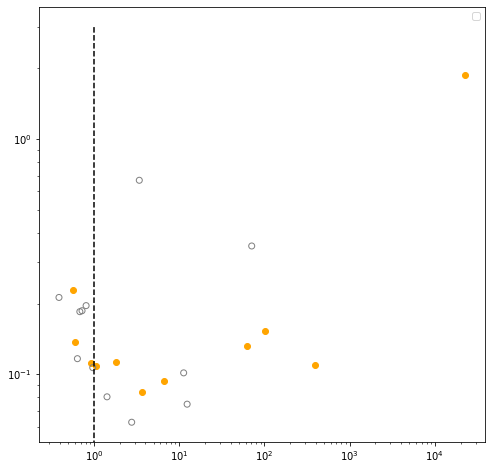

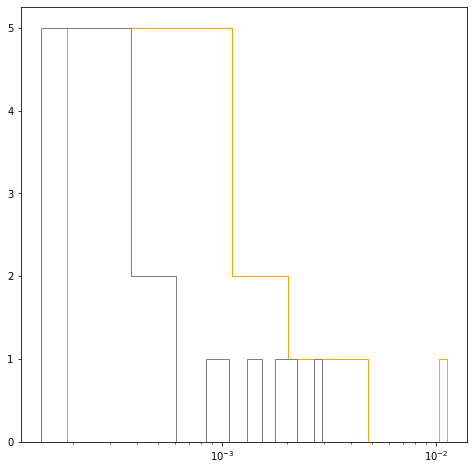

No handles with labels found to put in legend.


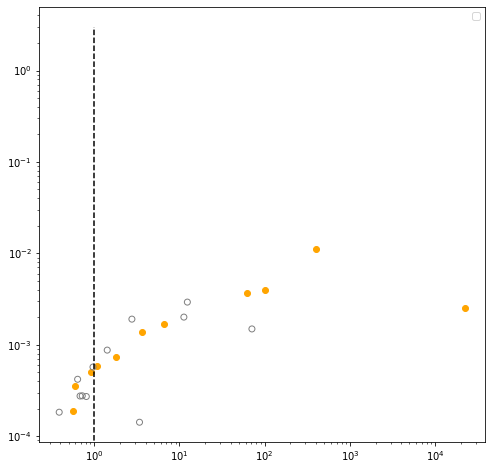

In [659]:
plt.figure(figsize=(8,8))
plt.scatter(gxYes.eta, gxYes.V, c='orange')
plt.scatter(gxNo.eta, gxNo.V,facecolors='none', edgecolors='grey')
plt.vlines(1, ymin=0, ymax=3, color='black',ls='--')
ax=plt.gca()
ax.set(yscale='log',xscale='log')
plt.show()

plt.figure(figsize=(8,8))
plt.hist(gxYes.medFlux, color='orange',histtype='step',bins=12)
plt.hist(gxNo.medFlux,color='grey',histtype='step',bins=12)
ax=plt.gca()
ax.set(xscale='log')
plt.show()

plt.figure(figsize=(8,8))
plt.scatter(gxYes.eta, gxYes.medFlux, c='orange')
plt.scatter(gxNo.eta, gxNo.medFlux, facecolors='none', edgecolors='grey')
plt.vlines(1, ymin=0, ymax=3, color='black',ls='--')
plt.legend()
ax=plt.gca()
ax.set(yscale='log',xscale='log')
plt.show()

8704 170
8037 170


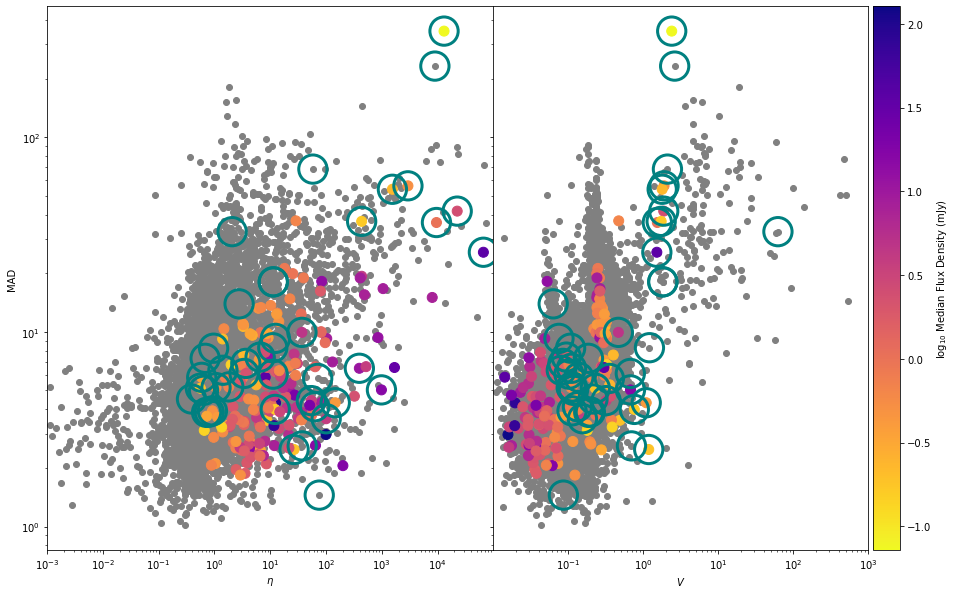

In [61]:
#compare eta and V to MAD        
Background = data[data['t/v']!=1]
CitSciTs = data[data['t/v']==1]


#must prune sources with 1dp, for which MAD doesnt compute:
Background = Background[Background['MAD']>1.000000001]
print(len(Background),len(CitSciTs))

c =np.log10(CitSciTs["medFlux"]*1000)
fig, axes = plt.subplots(1, 2, figsize=(16,10), sharey=True, squeeze=True)
fig.subplots_adjust(hspace=0,wspace=0)
ax1=axes[0]
ax2=axes[1]

ax1.scatter(Background['eta'],Background['MAD'],c='grey')
ax1.scatter(CitSciTs['eta'],CitSciTs['MAD'],c = c, cmap = "plasma_r" , s = 100)
ax1.scatter(VDF.eta,VDF.MAD, s=800,lw=3,facecolors='none', edgecolors='teal', label = 'Known Variables')
ax1.set(xscale='log' , yscale ='log',xlabel = '$\eta$', ylabel='MAD',xlim=(1e-2,1e5))

#prune overlapping labels in xaxis



#2nd subplot:
ax2.sharey(ax1)
ax2.scatter(Background['V'],Background['MAD'],c='grey')
plt1=ax2.scatter(CitSciTs['V'],CitSciTs['MAD'],c = c, cmap = "plasma_r" , s = 100)
ax2.scatter(VDF.V,VDF.MAD, s=800,lw=3,facecolors='none', edgecolors='teal', label = 'Known Variables')
ax2.set(xscale='log',xlabel = '$V$',xlim=(1e-2,1e2))

#prune overlapping labels in xaxis
T2=ax2.get_xticks()
ax2.set_xticks(T2[2:])
T1=ax1.get_xticks()
ax1.set_xticks(T1[:-2])

cbar = fig.colorbar(plt1, pad=0.01).set_label('log$_{10}$ Median Flux Density (mJy)')

plt.show()

In [395]:
#print(len(data[data['t/v']==2]))
#print(len(data[data['t/v']==1]))
#print(len(data[data['t/v']==0]))
'''
def scatterMarginals(data,x,y,xlims=None,ylims=None):
    fig = plt.figure(figsize=(12,12))
    ax=plt.gca()
    Background = data[data['t/v']!=1]
    CitSciTs = data[data['t/v']==1]
    ExpertOnly = data[data['t/v']==2]
    
    plt.scatter(Background[x], Background[y], c = "grey" , s = 100, alpha=0.5)
    plt.scatter(CitSciTs[x], CitSciTs[y], c = CitSciTs.transFrac, cmap = "viridis" , s = 100)
    plt.colorbar(pad = 0.01, fraction = 0.047).set_label('Transient Vote Fraction')

    #plt.scatter(ExpertOnly[x],ExpertOnly[y],c='purple',s=100,marker='s')
    plt.scatter(VDF[x],VDF[y], s=800,lw=3,facecolors='none', edgecolors='teal', label = 'Known Variables')

    ax.axvline(x=1, color='black', ls=':') 

    ax.set(xscale='log' , yscale ='log',xlabel = x, ylabel=y, ylim=ylims,xlim=xlims)
    ax.legend(markerscale=0.5, fontsize='large')

    divider = make_axes_locatable(ax)
    # below height and pad are in inches
    ax_histx = divider.append_axes("top", 1.2, pad=0.1, sharex=ax)
    ax_histy = divider.append_axes("right", 1.2, pad=0.1, sharey=ax)


    ax_histx.hist(CitSciTs[x])#, bins = 10 ** np.linspace(np.log10(min(CitSciTs[x]+1)), np.log10(max(CitSciTs[x]+1)),50)-1,
                  #color='purple',density=True)
    ax_histy.hist(CitSciTs[y])#,bins = 10 ** np.linspace(np.log10(1), np.log10(max(CitSciTs[y]+1)),200)-1,
                  #orientation='horizontal', color='purple',density=True)
    ax_histx.hist(Background[x])#, bins = 10 ** np.linspace(np.log10(min(Background[x]+1)), np.log10(max(Background[x]+1)),500)-1,
                  #color='grey',alpha=0.5,density=True)
    ax_histy.hist(Background[y])#, bins = 10 ** np.linspace(np.log10(1), np.log10(max(Background[y]+1)),1000)-1,
                  #orientation='horizontal', color='grey',alpha=0.8,density=True)
    plt.show()
    return None
scatterMarginals(data,x='eta',y='V',xlims=None,ylims=(0.01,100))

scatterMarginals(data,x='transFrac',y='N_datapoints')
'''

'\ndef scatterMarginals(data,x,y,xlims=None,ylims=None):\n    fig = plt.figure(figsize=(12,12))\n    ax=plt.gca()\n    Background = data[data[\'t/v\']!=1]\n    CitSciTs = data[data[\'t/v\']==1]\n    ExpertOnly = data[data[\'t/v\']==2]\n    \n    plt.scatter(Background[x], Background[y], c = "grey" , s = 100, alpha=0.5)\n    plt.scatter(CitSciTs[x], CitSciTs[y], c = CitSciTs.transFrac, cmap = "viridis" , s = 100)\n    plt.colorbar(pad = 0.01, fraction = 0.047).set_label(\'Transient Vote Fraction\')\n\n    #plt.scatter(ExpertOnly[x],ExpertOnly[y],c=\'purple\',s=100,marker=\'s\')\n    plt.scatter(VDF[x],VDF[y], s=800,lw=3,facecolors=\'none\', edgecolors=\'teal\', label = \'Known Variables\')\n\n    ax.axvline(x=1, color=\'black\', ls=\':\') \n\n    ax.set(xscale=\'log\' , yscale =\'log\',xlabel = x, ylabel=y, ylim=ylims,xlim=xlims)\n    ax.legend(markerscale=0.5, fontsize=\'large\')\n\n    divider = make_axes_locatable(ax)\n    # below height and pad are in inches\n    ax_histx = divider.

In [14]:
def FindKnownVariables(data, Field, runcatList):
    '''
    A tiny function used to manually locate known variables in a given field (i.e. different SubjectSetID)
    Simply match to the right SubjectSetID, then within that to the runcats of interest
    Args:
    data (pandas DataFrane): The reduced, aggregated classifications for the whole project.
    SubjectSetID (int): A unique ID for subject sets, which I uploaded on a per-field basis i.e. 1 ID per field.
    runcatList (list of strings): a list of variables of interest to the user.

    Returns: 
    MyVariables (pandas DataFrame): small dataframe of the requested classifications
    '''
    
    #MySubjectSet = data.loc[data['subject_set_id'] == Field].loc[MySubjectSet['runcat'].isin(runcatList)]
    #MyVariables = MySubjectSet.loc[MySubjectSet['runcat'].isin(runcatList)]
    
    MyVariables = data[data['Field']==Field].loc[data['runcat'].isin(runcatList)]
    return MyVariables

In [41]:
len(FindKnownVariables(data,'GX339' , [10165,10181,10204,10224,10233,10235,10239,10209,10280,10293,
                    10266,10264,10317,10736,10334,10484,10486,10449,
                    10496,10559,10609,10657,10663]))


23

In [15]:
def voteThreshold(data, thresh):
    '''
    A function to make a cut on aggregated data given some acceptable threshold. 
    Args:
    data (pandas DataFrame): The reduced, aggregated classifications for the whole project.
    thresh (float): the user defined threshold

    Returns: 
    MajorTrans (pandas DataFrame): dataframe of the sources which pass this threshold in the transient votes
    '''
    MajorTrans = data[data['transFrac']>= thresh]
    MS= data[data['stableFrac']>=thresh]
    ME= data[data['extendFrac']>=thresh]
    MU=data[data['unsureFrac']>=thresh]
    MA = data[data['arteFrac']>=thresh]
    TU = data[data['T+U'] >=thresh]
    print(len(MajorTrans['subject_id']), 'transient candidates with Vote Fracion >= ',thresh)
    print(len(MU['subject_id']), 'Unsure candidates with Vote Fracion >= ',thresh)
    print(len(TU['subject_id']), 'T+U candidates with Vote Fracion >= ',thresh)
    
    return [MajorTrans, MU, TU]

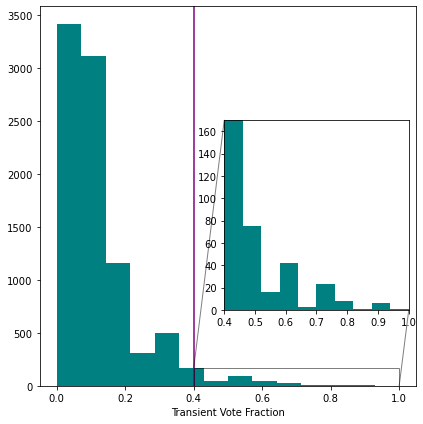

In [485]:
#plt.hist(data[ (0.49<= data['transFrac']) &  (data['transFrac']<= 0.501)]['Sum'])
T=0.4
plt.figure(figsize=(6,6))
ax = plt.gca()
plt.hist(data['transFrac'], color = 'teal', bins =14)#
plt.axvline(T, color='purple')
plt.xlabel('Transient Vote Fraction')

#plt.yscale('log')

ax2 = ax.inset_axes([0.49,0.2,0.49,0.5])
ax2.hist(data[data['transFrac']>=0.4]['transFrac'], color = 'teal', bins =10)
ax2.set_xlim(0.4,1)
ax2.set_ylim(0,170)
ax.indicate_inset_zoom(ax2, edgecolor="black")
plt.tight_layout()
#plt.savefig('dist.png')
plt.show()

In [86]:
def getDataFiles(data, savepath):
    '''
    A tiny function to iterate through a dataframe (or derivative dataframe therefrom) and use the url columns
    to pull images from the Zooniverse server.
    Args:
    data (pandas DataFrame): the data you are pulling urls from.
    savepath (str): the path to the folder in which these images will be saved.
    Returns: 0
    
    '''
    for index, row in data.iterrows():
        # calling urlretrieve function to get resource
        urllib.request.urlretrieve(row["LCurl"], savepath + row["LC"])
        urllib.request.urlretrieve(row["Imageurl"], savepath + row["Image"])
    print()
    return(len(data))

In [618]:
#getDataFiles(VDF,'./TraPData/Knowns/')

43

In [206]:
pd.set_option('display.max_rows', 200)
Unknowns = data[(data['Known?']==0) & (data['t/v']==1)]
#getDataFiles(Unknowns[Unknowns['medFlux']*1000 >=1], './TraPData/Unknown>1mJy/')



Pikkys = Unknowns[(Unknowns['medFlux']*1000 >=1) & (Unknowns['FracVar']>=0.2)]
#getDataFiles(Pikkys, './TraPData/PikkySample/')
#plt.hist(np.log10(Pikkys.medFlux*1000),bins=10)
#plt.xlabel('log10 Median Flux Density (mJy)')
#plt.show()


#print(Pikkys['RA_y'])
#print(MLMags['RA_y'])

#Pikkys = pd.merge(MLMags, Pikkys, how='inner', on=['RA_y'])
Pikkys


,Field,subject_id,workflow_id_x,task,reducer,data.stable,data.unsure,data.extended-blob,data.aggregation_version,data.transient-variable,data.artefact,Sum,transFrac,stableFrac,extendFrac,unsureFrac,arteFrac,T+U,project_id,workflow_id_y,subject_set_id,metadata,locations,classifications_count,retired_at,retirement_reason,created_at,updated_at,LC,RA_x,Dec_x,Image,runcat,date_obs,medianFlux(mJy),LCurl,Imageurl,eta,V,maxFlux,medFlux,avgFlux,coord_datapoints,newSource,RA_y,RA_err,Dec_y,Dec_err,t/v,Extended?,Notes,N_datapoints,MedianFlux,MeanFlux,MaximumFlux,MinimumFlux,MAD,eta2,V2,pc_dist(arcmin),Known?,FracVar
6608,MAXIJ1348,70795913,19109,T0,question_reducer,1.0,0.0,2.0,3.6.0,5.0,2.0,10.0,0.500000,0.100000,0.200000,0.000000,0.200000,0.500000,15976,19109.0,100070,"{""LC"":""132_ra207.308_dec-62.922_MAXIJ1348TraPDB_anderssonLC.png"",""RA"":""207.30761774839002"",""Dec"":""-62.922206009795296"",""Image"":""132_ra207.308_dec-62.922_MAXIJ1348TraPDB_anderssonImage.png"",""runcat"":""132"",""date_obs"":""2019-11-17T00:00:00.000"",""medianFlux(mJy)"":""1.9984349503665302""}","{""0"":""https://panoptes-uploads.zooniverse.org/subject_location/bb6b7f85-7389-4948-9450-cab2251cb7f3.png"",""1"":""https://panoptes-uploads.zooniverse.org/subject_location/8711e586-4c1d-40b2-8cc8-f4cb75eee43f.png""}",10,2022-02-03 02:22:49 UTC,classification_count,2021-12-03 16:59:18 UTC,2021-12-03 16:59:18 UTC,132_ra207.308_dec-62.922_MAXIJ1348TraPDB_anderssonLC.png,207.30761774839002,-62.922206009795296,132_ra207.308_dec-62.922_MAXIJ1348TraPDB_anderssonImage.png,132,2019-11-17T00:00:00.000,1.998435,https://panoptes-uploads.zooniverse.org/subject_location/bb6b7f85-7389-4948-9450-cab2251cb7f3.png,https://panoptes-uploads.zooniverse.org/subject_location/8711e586-4c1d-40b2-8cc8-f4cb75eee43f.png,2.931199,0.065449,0.002406,0.001998,0.002026,51,N,207.307525,0.000195,-62.922225,0.000195,1.0,0.0,0,51.0,0.001998,0.002026,0.002406,0.001853,5.483965,2.931199,0.065449,22.214720,0.0,0.277052
6998,MAXIJ1348,70796444,19109,T0,question_reducer,0.0,3.0,3.0,3.6.0,4.0,0.0,10.0,0.400000,0.000000,0.300000,0.300000,0.000000,0.700000,15976,19109.0,100070,"{""LC"":""53_ra207.993_dec-63.692_MAXIJ1348TraPDB_anderssonLC.png"",""RA"":""207.993280919848"",""Dec"":""-63.692587541718204"",""Image"":""53_ra207.993_dec-63.692_MAXIJ1348TraPDB_anderssonImage.png"",""runcat"":""53"",""date_obs"":""2019-03-01T00:00:00.000"",""medianFlux(mJy)"":""2.3144575391597""}","{""0"":""https://panoptes-uploads.zooniverse.org/subject_location/32685adf-80bc-4969-aca9-ba9dfc935eb6.png"",""1"":""https://panoptes-uploads.zooniverse.org/subject_location/d50d9ab2-bed4-41aa-802d-da86420dc5e4.png""}",10,2022-02-01 17:34:54 UTC,classification_count,2021-12-03 17:01:19 UTC,2021-12-03 17:01:19 UTC,53_ra207.993_dec-63.692_MAXIJ1348TraPDB_anderssonLC.png,207.993280919848,-63.692587541718204,53_ra207.993_dec-63.692_MAXIJ1348TraPDB_anderssonImage.png,53,2019-03-01T00:00:00.000,2.314458,https://panoptes-uploads.zooniverse.org/subject_location/32685adf-80bc-4969-aca9-ba9dfc935eb6.png,https://panoptes-uploads.zooniverse.org/subject_location/d50d9ab2-bed4-41aa-802d-da86420dc5e4.png,3.675057,0.068498,0.002861,0.002314,0.002350,51,N,207.993430,0.000195,-63.692433,0.000195,1.0,0.0,marginal,51.0,0.002314,0.002350,0.002861,0.002047,6.109259,3.675057,0.068498,35.559803,0.0,0.351715
4198,4U1543,70793035,19109,T0,question_reducer,4.0,0.0,0.0,3.6.0,6.0,0.0,10.0,0.600000,0.400000,0.000000,0.000000,0.000000,0.600000,15976,19109.0,100065,"{""LC"":""620_ra235.482_dec-47.815_4U1543TraPDB_anderssonLC.png"",""RA"":""235.48185806877004"",""Dec"":""-47.8154870798373"",""Image"":""620_ra235.482_dec-47.815_4U1543TraPDB_anderssonImage.png"",""runcat"":""620"",""date_obs"":""2021-10-31T13:11:42.930"",""medianFlux(mJy)"":""1.94310356105225""}","{""0"":""https://panoptes-uploads.zooniverse.org/subject_location/54d14ff6-f343-4ea2-91d3-d97453245d1f.png"",""1"":""https://panoptes-uploads.zooniverse.org/subject_location/7efe72b7-2b73-44f7-b2a1-18a3434d4363.p

In [166]:
import shutil
for i, file in enumerate(glob.iglob('/Users/andersson/Documents/Zoo/TraPData/AllLightCurves/*/*',recursive=True)):
    LC = pd.read_csv(file)
    f = file.split('/')[-1].split('_')[-2].rstrip('TraPDB')
    if 'dec' in f:
        f = 'GX339'
    runcat = int(file.split('/')[-1].split('_')[0])
    #LC['Field'] = f
    #LC['runcat'] = runcat
    #LC = LC.astype({'runcat':'int64'})
    
    idx = data[(data['Field']==f )& (data['runcat']==runcat)].index#['LCdf'] = LC

    if idx[0] in Pikkys.index:
        LCname = Pikkys.loc[idx,'LC'].values[0][:-6]+'.csv'
        pre = '/Users/andersson/Documents/Zoo/TraPData/'
        fromm = pre + 'LightCurves/'+ LCname
        to = pre +'PikkySampleLCs/'+LCname
        shutil.copyfile(fromm, to)

/Users/andersson/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


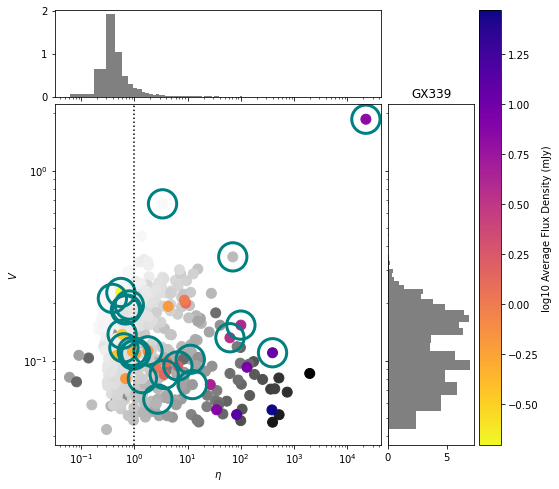

/Users/andersson/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


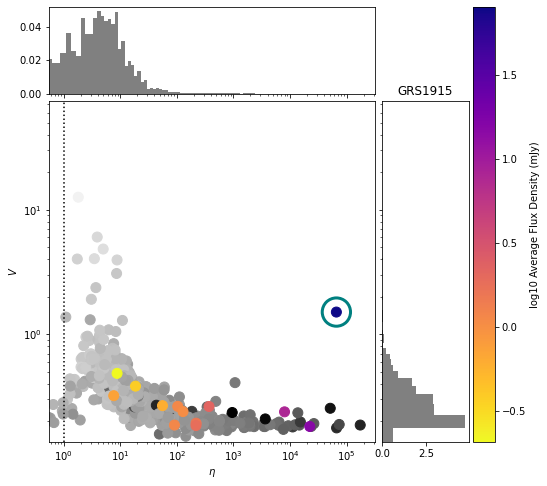

/Users/andersson/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


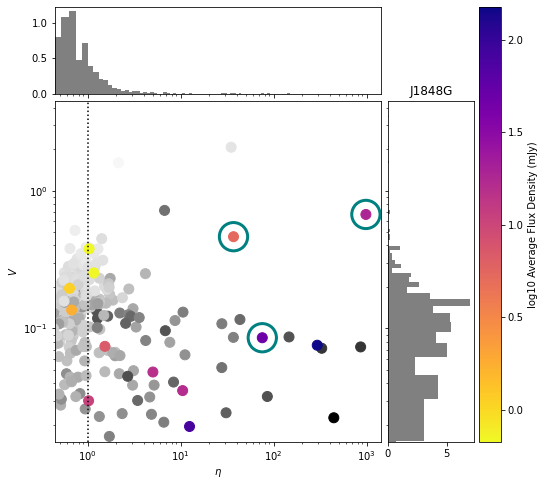

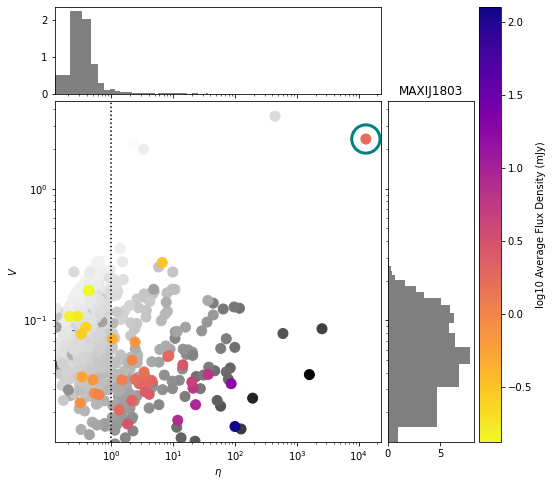

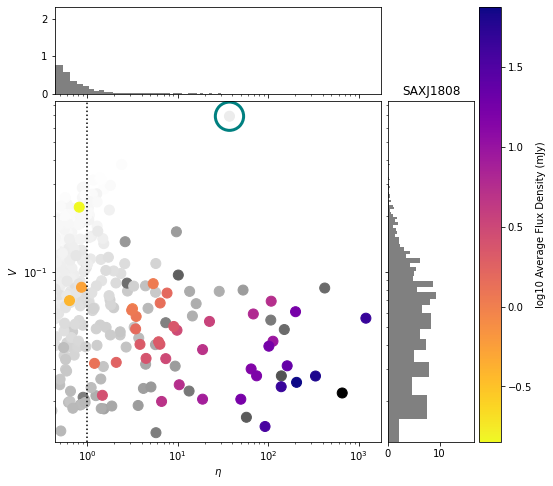

/Users/andersson/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


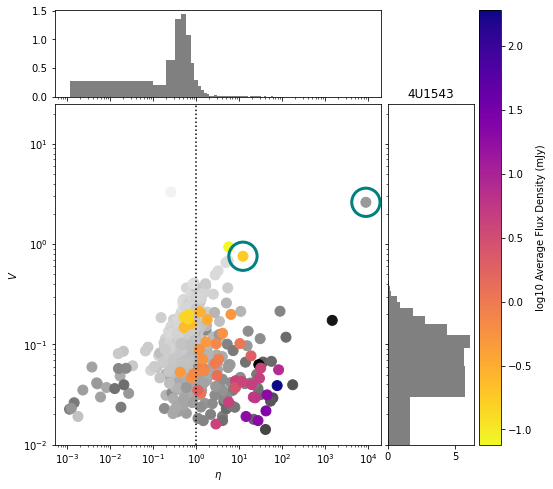

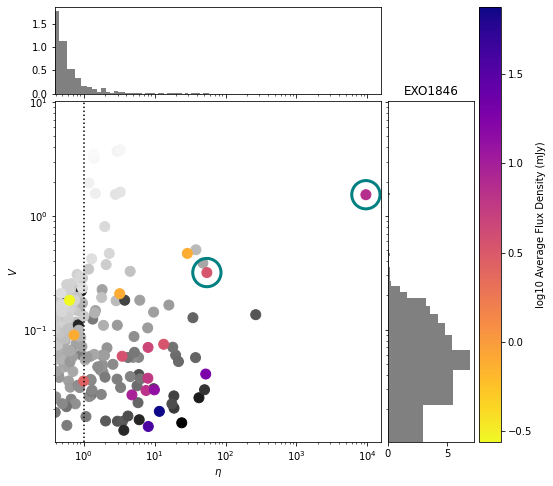

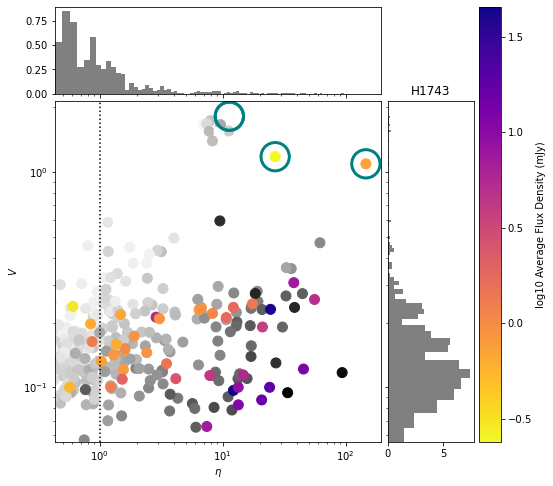

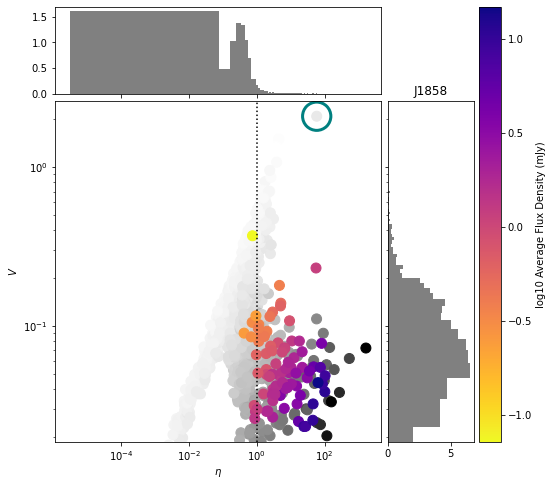

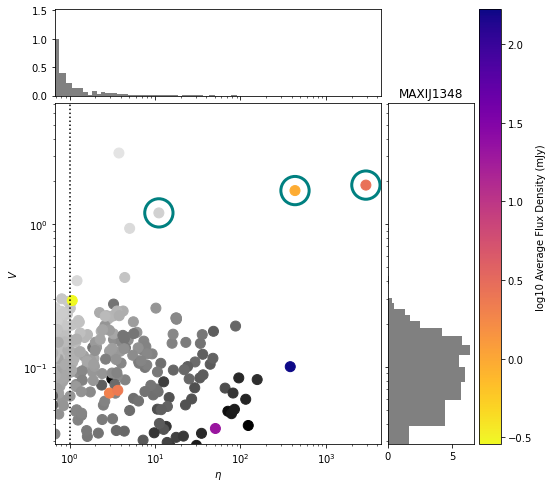

/Users/andersson/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


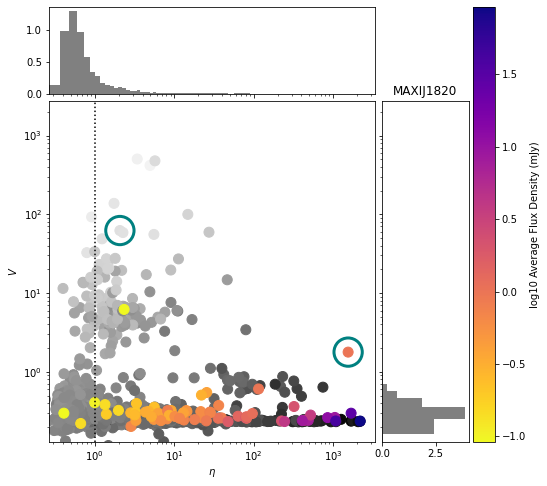

381 8493
381 8493


/Users/andersson/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


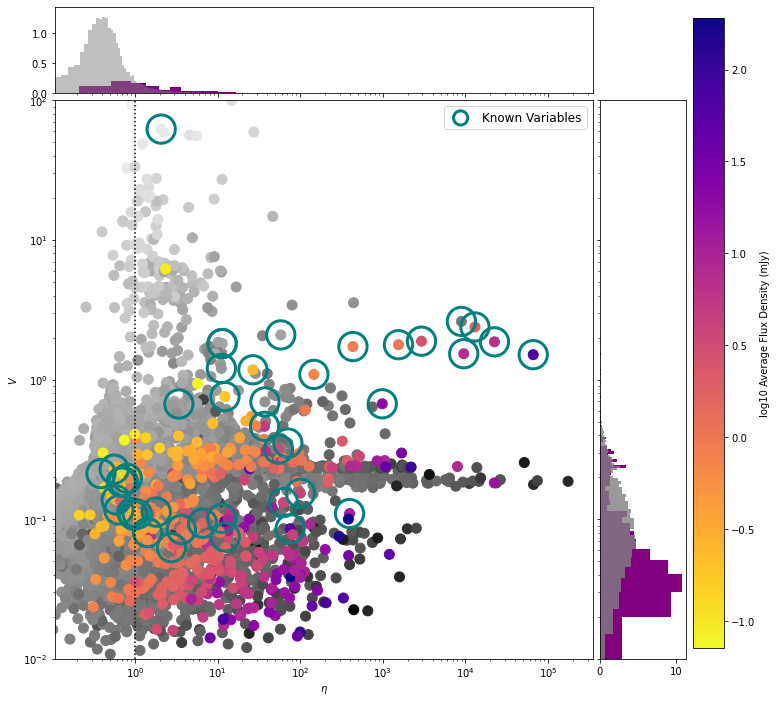

In [17]:
T=0.4

from mpl_toolkits.axes_grid1 import make_axes_locatable

t,f = 0,0
for field in data['Field'].unique():
    fieldData = data[data['Field'] == field]

    fieldT = fieldData[fieldData['transFrac']>=T]
    fieldF = fieldData[fieldData['transFrac']<T]
    t += len(fieldT)
    f += len(fieldF)
    
    Knowns = VDF[VDF['Field']==field]

    fig = plt.figure(figsize=(8,8))
    ax=plt.gca()
    plt.scatter(fieldF.eta, fieldF.V, c = np.log10(fieldF["avgFlux"]*1000), cmap = "Greys" , s = 100)
    #plt.colorbar(pad = 0.01, fraction = 0.05).set_label('log10 Average Flux Density (mJy)')

    plt.scatter(fieldT.eta, fieldT.V, c = np.log10(fieldT["avgFlux"]*1000), cmap = "plasma_r" , s = 100)
    plt.colorbar(pad = 0.01, fraction = 0.05).set_label('log10 Average Flux Density (mJy)')
    
    ax.scatter(Knowns.eta,Knowns.V, s=800,lw=3,facecolors='none', edgecolors='teal')
    
    ax.axvline(x=1, color='black', ls=':') 
    
    ax.set_xscale('log')
    ax.set_yscale('log')  
    ax.set_xlabel("$\eta$")
    ax.set_ylabel("$V$")
    #ax.set_xlim(min(fieldData.eta),max(fieldData.eta))
    #ax.set_ylim(min(fieldData.V),max(fieldData.V))
    
    divider = make_axes_locatable(ax)
    # below height and pad are in inches
    ax_histx = divider.append_axes("top", 1.2, pad=0.1, sharex=ax)
    ax_histy = divider.append_axes("right", 1.2, pad=0.1, sharey=ax)

    ax_histx.hist(fieldData.eta, bins = 10 ** np.linspace(np.log10(min(fieldData.eta+1)), np.log10(max(fieldData.eta+1)),100)-1,
                  color='grey',density=True)
    ax_histy.hist(fieldData.V,   bins = 10 ** np.linspace(np.log10(1), np.log10(max(fieldData.V++1)),100)-1,
                  orientation='horizontal', color='grey',density=True)
    
    
    ax_histx.xaxis.set_tick_params(labelbottom=False)
    ax_histy.yaxis.set_tick_params(labelleft=False)
    plt.title(field)
    plt.show()

print(t,f)

MajorTrans = data[data['transFrac']>= T]

Background = data[data['transFrac'] < T]
print(len(MajorTrans),len(Background))

fig = plt.figure(figsize=(12,12))
ax=plt.gca()

plt.scatter(Background.eta, Background.V, c = np.log10(Background["avgFlux"]*1000), cmap = "Greys" , s = 100)
#plt.colorbar(pad = 0.01, fraction = 0.047).set_label('log10 Average Flux Density (mJy)')

plt.scatter(MajorTrans.eta, MajorTrans.V, c = np.log10(MajorTrans["avgFlux"]*1000), cmap = "plasma_r" , s = 100)
plt.colorbar(pad = 0.01, fraction = 0.047).set_label('log10 Average Flux Density (mJy)')

plt.scatter(VDF.eta,VDF.V, s=800,lw=3,facecolors='none', edgecolors='teal', label = 'Known Variables')
    
ax.axvline(x=1, color='black', ls=':') 

ax.set(xscale='log' , yscale ='log',xlabel = "$\eta$", ylabel="$V$", ylim=(0.01,100))
ax.legend(markerscale=0.5, fontsize='large')

divider = make_axes_locatable(ax)
# below height and pad are in inches
ax_histx = divider.append_axes("top", 1.2, pad=0.1, sharex=ax)
ax_histy = divider.append_axes("right", 1.2, pad=0.1, sharey=ax)


ax_histx.hist(MajorTrans.eta, bins = 10 ** np.linspace(np.log10(min(MajorTrans.eta+1)), np.log10(max(MajorTrans.eta+1)),50)-1,
              color='purple',density=True)
ax_histy.hist(MajorTrans.V,bins = 10 ** np.linspace(np.log10(1), np.log10(max(MajorTrans.V+1)),200)-1,
              orientation='horizontal', color='purple',density=True)
ax_histx.hist(Background.eta, bins = 10 ** np.linspace(np.log10(min(Background.eta+1)), np.log10(max(Background.eta+1)),500)-1,
              color='grey',alpha=0.5,density=True)
ax_histy.hist(Background.V, bins = 10 ** np.linspace(np.log10(1), np.log10(max(Background.V+1)),1000)-1,
              orientation='horizontal', color='grey',alpha=0.8,density=True)

ax_histx.xaxis.set_tick_params(labelbottom=False)
ax_histy.yaxis.set_tick_params(labelleft=False)

 
plt.show()

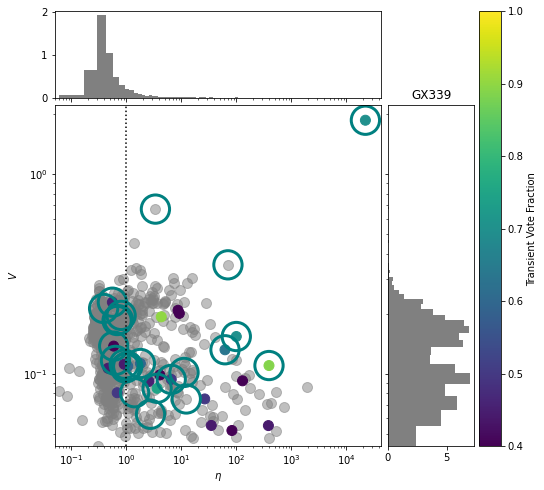

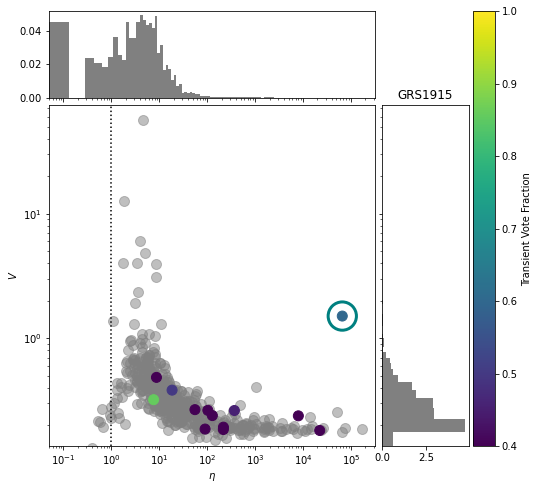

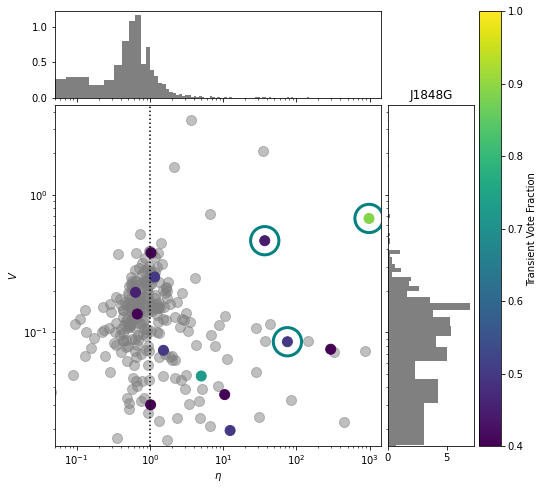

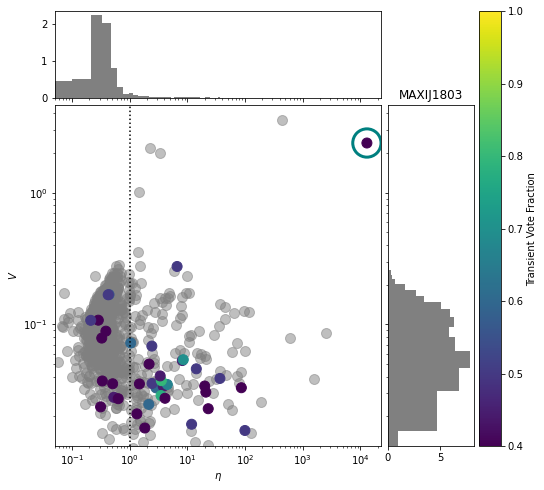

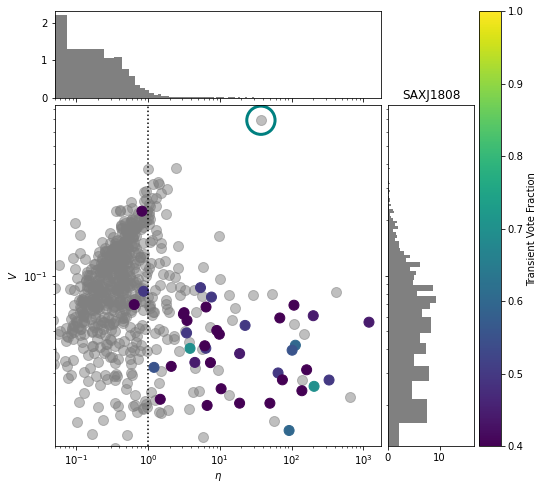

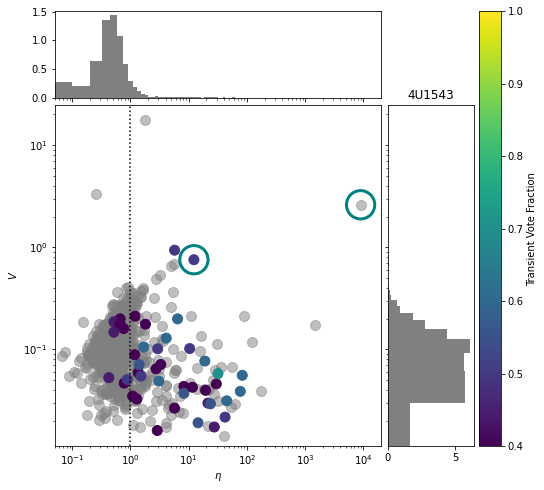

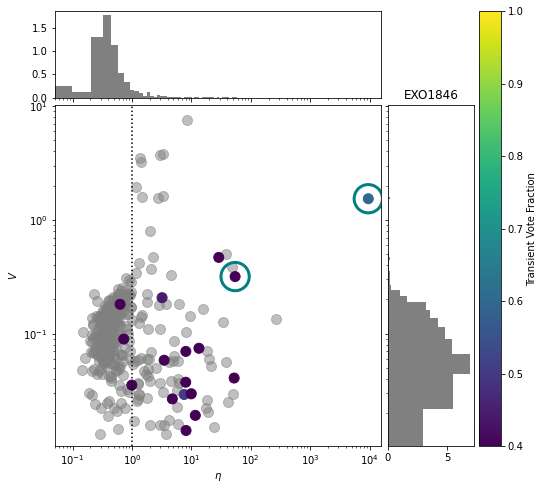

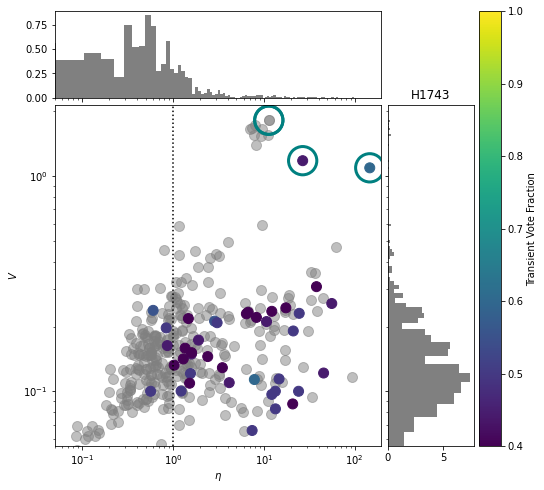

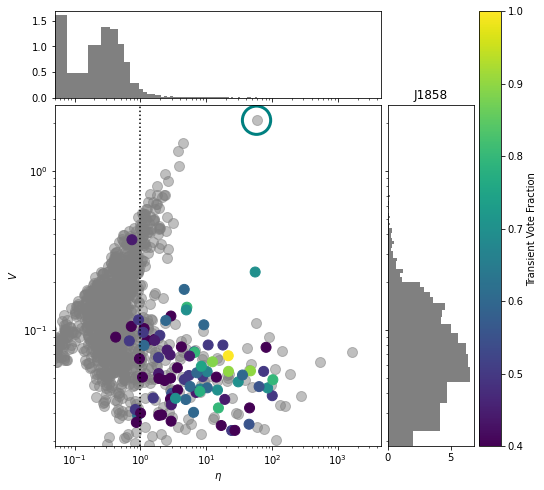

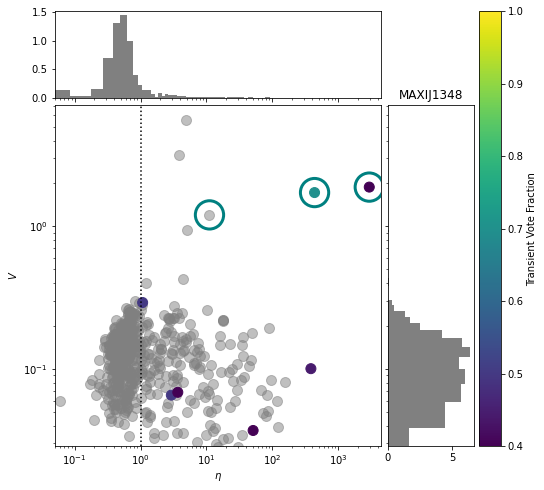

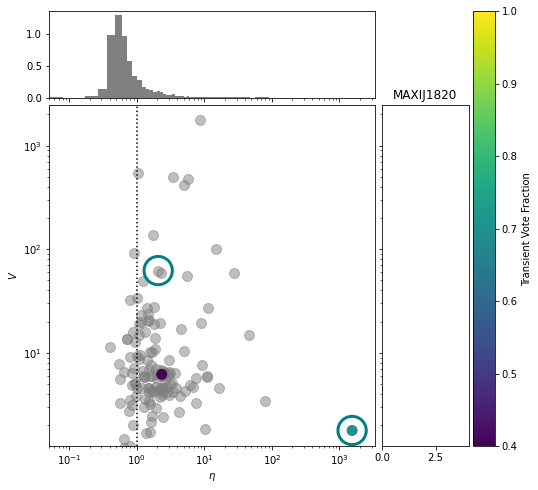

381 8493
381 8493


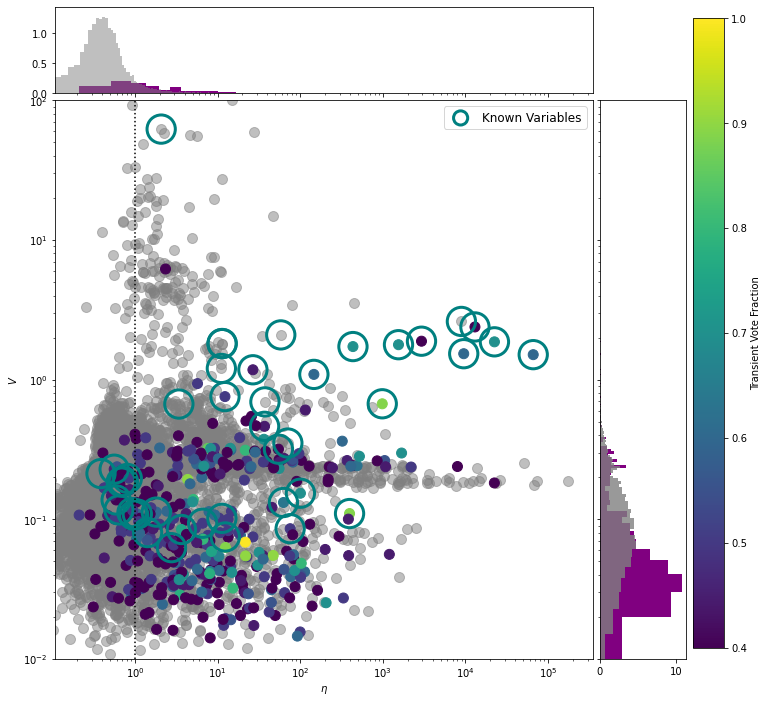

In [18]:
# for the whole dataset
T=0.4

from mpl_toolkits.axes_grid1 import make_axes_locatable

t,f = 0,0
for field in data['Field'].unique():
    fieldData = data[data['Field'] == field]

    fieldT = fieldData[fieldData['transFrac']>=T]
    fieldF = fieldData[fieldData['transFrac']<T]
    t += len(fieldT)
    f += len(fieldF)
    
    Knowns = VDF[VDF['Field']==field]

    fig = plt.figure(figsize=(8,8))
    ax=plt.gca()
    plt.scatter(fieldF.eta, fieldF.V, c = "grey",alpha=0.5 , s = 100) #could also do a colour map?
    #plt.colorbar(pad = 0.01, fraction = 0.05).set_label('log10 Average Flux Density (mJy)')

    plt.scatter(fieldT.eta, fieldT.V, c = fieldT["transFrac"], cmap = "viridis" , s = 100,vmin=T,vmax=1.0)
    plt.colorbar(pad = 0.01, fraction = 0.05).set_label('Transient Vote Fraction')
    
    ax.scatter(Knowns.eta,Knowns.V, s=800,lw=3,facecolors='none', edgecolors='teal')
    
    ax.axvline(x=1, color='black', ls=':') 
    
    ax.set_xscale('log')
    ax.set_yscale('log')  
    ax.set_xlabel("$\eta$")
    ax.set_ylabel("$V$")
    ax.set_xlim(0.05)
    #ax.set_ylim(0.01)
    
    divider = make_axes_locatable(ax)
    # below height and pad are in inches
    ax_histx = divider.append_axes("top", 1.2, pad=0.1, sharex=ax)
    ax_histy = divider.append_axes("right", 1.2, pad=0.1, sharey=ax)

    ax_histx.hist(fieldData.eta, bins = 10 ** np.linspace(np.log10(min(fieldData.eta+1)), np.log10(max(fieldData.eta+1)),100)-1,
                  color='grey',density=True)
    ax_histy.hist(fieldData.V,   bins = 10 ** np.linspace(np.log10(1), np.log10(max(fieldData.V++1)),100)-1,
                  orientation='horizontal', color='grey',density=True)
    
    
    ax_histx.xaxis.set_tick_params(labelbottom=False)
    ax_histy.yaxis.set_tick_params(labelleft=False)
    plt.title(field)
    plt.show()

print(t,f)

MajorTrans = data[data['transFrac']>= T]
Background = data[data['transFrac'] < T]
print(len(MajorTrans),len(Background))

fig = plt.figure(figsize=(12,12))
ax=plt.gca()

plt.scatter(Background.eta, Background.V, c = "grey" , s = 100, alpha=0.5)
#plt.colorbar(pad = 0.01, fraction = 0.047).set_label('log10 Average Flux Density (mJy)')

plt.scatter(MajorTrans.eta, MajorTrans.V, c = MajorTrans["transFrac"], cmap = "viridis" , s = 100)
plt.colorbar(pad = 0.01, fraction = 0.047).set_label('Transient Vote Fraction')

plt.scatter(VDF.eta,VDF.V, s=800,lw=3,facecolors='none', edgecolors='teal', label = 'Known Variables')
    
ax.axvline(x=1, color='black', ls=':') 

ax.set(xscale='log' , yscale ='log',xlabel = "$\eta$", ylabel="$V$", ylim=(0.01,100))
ax.legend(markerscale=0.5, fontsize='large')

divider = make_axes_locatable(ax)
# below height and pad are in inches
ax_histx = divider.append_axes("top", 1.2, pad=0.1, sharex=ax)
ax_histy = divider.append_axes("right", 1.2, pad=0.1, sharey=ax)


ax_histx.hist(MajorTrans.eta, bins = 10 ** np.linspace(np.log10(min(MajorTrans.eta+1)), np.log10(max(MajorTrans.eta+1)),50)-1,
              color='purple',density=True)
ax_histy.hist(MajorTrans.V,bins = 10 ** np.linspace(np.log10(1), np.log10(max(MajorTrans.V+1)),200)-1,
              orientation='horizontal', color='purple',density=True)
ax_histx.hist(Background.eta, bins = 10 ** np.linspace(np.log10(min(Background.eta+1)), np.log10(max(Background.eta+1)),500)-1,
              color='grey',alpha=0.5,density=True)
ax_histy.hist(Background.V, bins = 10 ** np.linspace(np.log10(1), np.log10(max(Background.V+1)),1000)-1,
              orientation='horizontal', color='grey',alpha=0.8,density=True)

ax_histx.xaxis.set_tick_params(labelbottom=False)
ax_histy.yaxis.set_tick_params(labelleft=False)

 
plt.show()

In [72]:
data

,Field,subject_id,workflow_id_x,task,reducer,data.stable,data.unsure,data.extended-blob,data.aggregation_version,data.transient-variable,data.artefact,Sum,transFrac,stableFrac,extendFrac,unsureFrac,arteFrac,T+U,project_id,workflow_id_y,subject_set_id,metadata,locations,classifications_count,retired_at,retirement_reason,created_at,updated_at,LC,RA_x,Dec_x,Image,runcat,date_obs,medianFlux(mJy),LCurl,Imageurl,eta,V,maxFlux,medFlux,avgFlux,coord_datapoints,newSource,RA_y,RA_err,Dec_y,Dec_err,t/v,Extended?,Notes,N_datapoints,MedianFlux,MeanFlux,MaximumFlux,MinimumFlux,MAD,eta2,V2,pc_dist(arcmin),Known?
0,GX339,70785283,19109,T0,question_reducer,6.0,1.0,2.0,3.6.0,0.0,0.0,9.0,0.0,0.666667,0.222222,0.111111,0.000000,0.111111,15976,19109.0,100043,"{""LC"":""10636_ra256.621_dec-48.149_anderssontra...","{""0"":""https://panoptes-uploads.zooniverse.org/...",10,2022-01-14 18:11:54 UTC,classification_count,2021-12-03 14:10:00 UTC,2021-12-03 14:10:00 UTC,10636_ra256.621_dec-48.149_anderssontrapLC.png,256.621117139368,-48.1489166733255,10636_ra256.621_dec-48.149_anderssontrapImage.png,10636,2021-03-08T00:00:00.000,0.263177,https://panoptes-uploads.zooniverse.org/subjec...,https://panoptes-uploads.zooniverse.org/subjec...,0.568889,0.175555,0.000402,0.000263,0.000263,18,N,256.621250,0.000329,-48.148688,0.000329,0.0,0.0,0,166.0,0.000263,0.000263,0.000402,0.000138,4.640011,0.568889,0.175555,52.968272,0.0
1,GX339,70785284,19109,T0,question_reducer,8.0,1.0,0.0,3.6.0,1.0,0.0,10.0,0.1,0.800000,0.000000,0.100000,0.000000,0.200000,15976,19109.0,100043,"{""LC"":""10628_ra256.555_dec-48.825_anderssontra...","{""0"":""https://panoptes-uploads.zooniverse.org/...",10,2022-02-06 18:47:00 UTC,classification_count,2021-12-03 14:10:00 UTC,2021-12-03 14:10:00 UTC,10628_ra256.555_dec-48.825_anderssontrapLC.png,256.555341864294,-48.824875405248605,10628_ra256.555_dec-48.825_anderssontrapImage.png,10628,2018-04-14T00:00:00.000,0.931652,https://panoptes-uploads.zooniverse.org/subjec...,https://panoptes-uploads.zooniverse.org/subjec...,1.097027,0.070521,0.001141,0.000932,0.000935,166,N,256.555326,0.000108,-48.824949,0.000108,0.0,0.0,0,166.0,0.000932,0.000935,0.001141,0.000621,7.989630,1.097027,0.070521,33.641313,0.0
2,GX339,70785285,19109,T0,question_reducer,8.0,2.0,0.0,3.6.0,0.0,0.0,10.0,0.0,0.800000,0.000000,0.200000,0.000000,0.200000,15976,19109.0,100043,"{""LC"":""10132_ra254.733_dec-48.563_anderssontra...","{""0"":""https://panoptes-uploads.zooniverse.org/...",10,2022-02-08 14:47:10 UTC,classification_count,2021-12-03 14:10:00 UTC,2021-12-03 14:10:00 UTC,10132_ra254.733_dec-48.563_anderssontrapLC.png,254.732728851156,-48.563562219775704,10132_ra254.733_dec-48.563_anderssontrapImage.png,10132,2018-04-14T00:00:00.000,0.232827,https://panoptes-uploads.zooniverse.org/subjec...,https://panoptes-uploads.zooniverse.org/subjec...,0.472002,0.189872,0.000361,0.000233,0.000237,5,N,254.732397,0.000625,-48.563505,0.000625,0.0,0.0,0,166.0,0.000233,0.000237,0.000361,0.000088,4.592135,0.472002,0.189872,40.877169,0.0
3,GX339,70785286,19109,T0,question_reducer,5.0,0.0,3.0,3.6.0,0.0,1.0,9.0,0.0,0.555556,0.333333,0.000000,0.111111,0.000000,15976,19109.0,100043,"{""LC"":""10529_ra256.135_dec-48.598_anderssontra...","{""0"":""https://panoptes-uploads.zooniverse.org/...",10,2022-02-14 02:32:14 UTC,classification_count,2021-12-03 14:10:00 UTC,2021-12-03 14:10:00 UTC,10529_ra256.135_dec-48.598_anderssontrapLC.png,256.135396262086,-48.5982446578128,10529_ra256.135_dec-48.598_anderssontrapImage.png,10529,2018-04-14T00:00:00.000,10.678822,https://panoptes-uploads.zooniverse.org/subjec...,https://panoptes-uploads.zooniverse.org/subjec...,54.601966,0.061160,0.012574,0.010679,0.010670,166,N,256.135428,0.000108,-48.598259,0.000108,0.0,0.0,0,166.0,0.010679,0.010670,0.012574,0.006101,14.976526,54.601966,0.061160,20.532743,0.0
4,GX339,70785287,19109,T0,question_reducer,5.0,2.0,2.0,3.6.0,0.0,0.0,9.0,0.0,0.555556,0.222222,0.222222,0.000000,0.222222,15976,19109.0,100043,"{""LC"":""10654_ra256.796_de

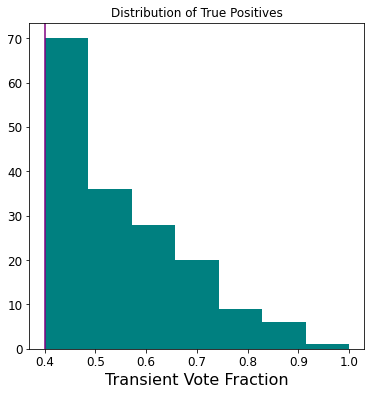

/Users/andersson/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/andersson/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


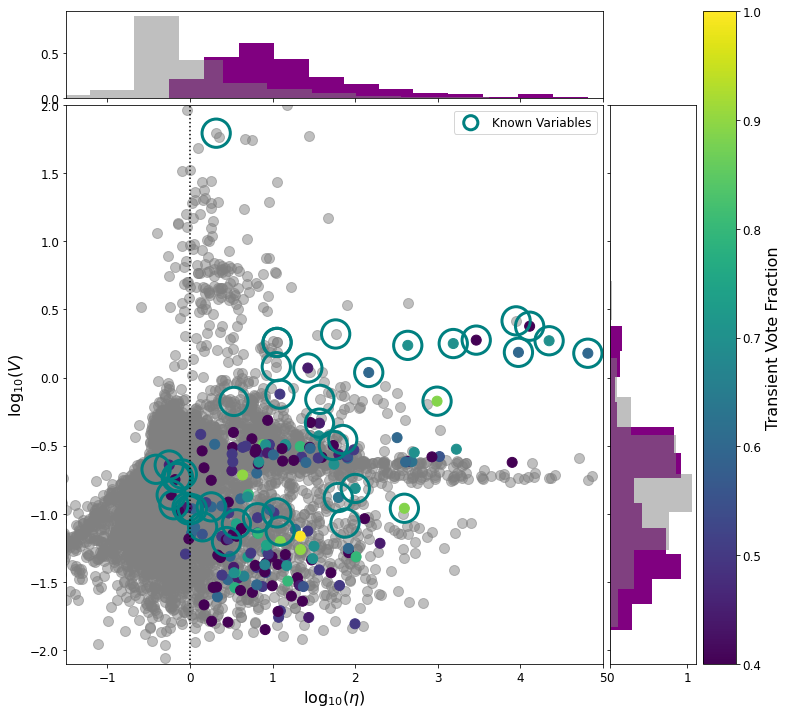

In [71]:
# for the expert labelled sample:

CitSciTs = data[data['t/v']==1]
Background = data[data['t/v']!=1]

plt.rc('axes', labelsize=16) 
plt.rc('xtick', labelsize=12)    
plt.rc('ytick', labelsize=12)

plt.figure(figsize=(6,6))
ax = plt.gca()
plt.title('Distribution of True Positives')
plt.hist(CitSciTs['transFrac'], color = 'teal', bins =7)#
plt.axvline(0.4, color='purple')
plt.xlabel('Transient Vote Fraction')
plt.show()


#eta V with marginal distribution
fig = plt.figure(figsize=(12,12))
ax=plt.gca()

plt.scatter(np.log10(Background.eta), np.log10(Background.V), c = "grey" , s = 100, alpha=0.5)
plt.scatter(np.log10(CitSciTs.eta), np.log10(CitSciTs.V), c = CitSciTs["transFrac"], cmap = "viridis" , s = 100)
plt.colorbar(pad = 0.01, fraction = 0.049).set_label('Transient Vote Fraction')

plt.scatter(np.log10(VDF.eta),np.log10(VDF.V), s=800,lw=3,facecolors='none', edgecolors='teal', label = 'Known Variables')
ax.axvline(x=0, color='black', ls=':') 


ax.set(xlabel = "log$_{10}(\eta)$", ylabel="log$_{10}(V)$", ylim=(-2.1,2), xlim=(-1.5,5))
#ax.set(xscale='log' , yscale ='log',xlabel = "$\eta$", ylabel="$V$", ylim=(0.01,100), xlim=(0.1,1e5))
ax.legend(markerscale=0.5, fontsize='large')

divider = make_axes_locatable(ax)
# below height and pad are in inches
ax_histx = divider.append_axes("top", 1.2, pad=0.1, sharex=ax)
ax_histy = divider.append_axes("right", 1.2, pad=0.1, sharey=ax)

'''
ax_histx.hist(CitSciTs.eta, bins = 10 ** np.linspace(np.log10(min(CitSciTs.eta+1)), np.log10(max(CitSciTs.eta+1)),50)-1,
              color='purple',density=True)

ax_histy.hist(CitSciTs.V,bins = 10 ** np.linspace(np.log10(1), np.log10(max(CitSciTs.V+1)),200)-1,
              orientation='horizontal', color='purple',density=True)
ax_histx.hist(Background.eta, bins = 10 ** np.linspace(np.log10(min(Background.eta+1)), np.log10(max(Background.eta+1)),500)-1,
              color='grey',alpha=0.5,density=True)
ax_histy.hist(Background.V, bins = 10 ** np.linspace(np.log10(1), np.log10(max(Background.V+1)),1000)-1,
              orientation='horizontal', color='grey',alpha=0.8,density=True)
              
              
'''
ax_histx.hist(np.log10(CitSciTs.eta), bins = 12,color='purple',density=True)
ax_histx.hist(np.nan_to_num(np.log10(Background.eta), neginf=0), bins = 20,color='grey',alpha=0.5,density=True)
ax_histy.hist(np.log10(CitSciTs.V),bins = 12, orientation='horizontal', color='purple',density=True)
ax_histy.hist(np.nan_to_num(np.log10(Background.V), neginf=0), bins = 20 , orientation='horizontal', color='grey',alpha=0.5,density=True)

ax_histx.xaxis.set_tick_params(labelbottom=False)
ax_histy.yaxis.set_tick_params(labelleft=False)

plt.savefig('etaV.pdf',bbox_inches='tight',transparent=False,facecolor='white')
plt.savefig('etaV.png',bbox_inches='tight',transparent=False,facecolor='white')

plt.show()

In [12]:
print(len(pd.merge(VDF, ELTs, how='inner', on=['subject_id'])))
print(len(VDF))
print(len(ELTs))
print(len(data))

23
43
170
8874


In [52]:
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_colwidth',1000)
ELTs.sort_values('transFrac', ascending=False).head(500)
#ELTs.to_csv('AGG.csv')

In [15]:
# MajorTrans
#fD= data[data['Field'] == 'MAXIJ1803']
fD= ELTs[ELTs['Field'] == 'MAXIJ1803']

#fD = fD[fD['eta'] >=10]
fD.sort_values('runcat', ascending=True).head(500)

,Field,subject_id,workflow_id_x,task,reducer,data.stable,data.unsure,data.extended-blob,data.aggregation_version,data.transient-variable,data.artefact,Sum,transFrac,stableFrac,extendFrac,unsureFrac,arteFrac,T+U,project_id,workflow_id_y,subject_set_id,metadata,locations,classifications_count,retired_at,retirement_reason,created_at,updated_at,LC,RA_x,Dec_x,Image,runcat,date_obs,medianFlux(mJy),LCurl,Imageurl,eta,V,maxFlux,medFlux,avgFlux,coord_datapoints,newSource,RA_y,RA_err,Dec_y,Dec_err,t/v,Extended?,Notes
77,MAXIJ1803,70790883,19109,T0,question_reducer,1.0,1.0,0.0,3.6.0,6.0,1.0,9.0,0.666667,0.111111,0.000000,0.111111,0.111111,0.777778,15976,19109.0,100062,"{""LC"":""38_ra271.545_dec-30.141_MAXIJ1803TraPDB...","{""0"":""https://panoptes-uploads.zooniverse.org/...",10,2022-02-13 21:21:54 UTC,classification_count,2021-12-03 16:26:08 UTC,2021-12-03 16:26:08 UTC,38_ra271.545_dec-30.141_MAXIJ1803TraPDB_anders...,271.545183742069,-30.1405705840883,38_ra271.545_dec-30.141_MAXIJ1803TraPDB_anders...,38,2021-05-27T23:30:11.800,2.086086,https://panoptes-uploads.zooniverse.org/subjec...,https://panoptes-uploads.zooniverse.org/subjec...,4.495760,0.034927,0.002212,0.002086,0.002094,28,N,271.545227,0.000262,-30.140628,0.000262,1,0,NaN
65,MAXIJ1803,70790438,19109,T0,question_reducer,5.0,0.0,0.0,3.6.0,5.0,0.0,10.0,0.500000,0.500000,0.000000,0.000000,0.000000,0.500000,15976,19109.0,100062,"{""LC"":""51_ra271.424_dec-30.144_MAXIJ1803TraPDB...","{""0"":""https://panoptes-uploads.zooniverse.org/...",10,2022-02-15 13:48:57 UTC,classification_count,2021-12-03 16:24:45 UTC,2021-12-03 16:24:45 UTC,51_ra271.424_dec-30.144_MAXIJ1803TraPDB_anders...,271.42392970557,-30.1436066095497,51_ra271.424_dec-30.144_MAXIJ1803TraPDB_anders...,51,2021-05-07T02:57:47.000,8.023460,https://panoptes-uploads.zooniverse.org/subjec...,https://panoptes-uploads.zooniverse.org/subjec...,11.857467,0.017420,0.008322,0.008023,0.008038,28,N,271.424027,0.000262,-30.143673,0.000262,1,0,same shape?
64,MAXIJ1803,70790384,19109,T0,question_reducer,4.0,0.0,2.0,3.6.0,4.0,0.0,10.0,0.400000,0.400000,0.200000,0.000000,0.000000,0.400000,15976,19109.0,100062,"{""LC"":""70_ra271.383_dec-30.411_MAXIJ1803TraPDB...","{""0"":""https://panoptes-uploads.zooniverse.org/...",10,2022-02-19 16:08:11 UTC,classification_count,2021-12-03 16:24:38 UTC,2021-12-03 16:24:38 UTC,70_ra271.383_dec-30.411_MAXIJ1803TraPDB_anders...,271.382692205134,-30.411291796914895,70_ra271.383_dec-30.411_MAXIJ1803TraPDB_anders...,70,2021-06-12T23:41:27.800,6.199286,https://panoptes-uploads.zooniverse.org/subjec...,https://panoptes-uploads.zooniverse.org/subjec...,20.932577,0.030543,0.006790,0.006199,0.006241,28,N,271.382755,0.000262,-30.411344,0.000262,1,0,NaN
49,MAXIJ1803,70789583,19109,T0,question_reducer,4.0,2.0,0.0,3.6.0,4.0,0.0,10.0,0.400000,0.400000,0.000000,0.200000,0.000000,0.600000,15976,19109.0,100062,"{""LC"":""76_ra271.374_dec-30.120_MAXIJ1803TraPDB...","{""0"":""https://panoptes-uploads.zooniverse.org/...",10,2022-02-19 20:14:26 UTC,classification_count,2021-12-03 16:22:52 UTC,2021-12-03 16:22:52 UTC,76_ra271.374_dec-30.120_MAXIJ1803TraPDB_anders...,271.373733221867,-30.1200349618949,76_ra271.374_dec-30.120_MAXIJ1803TraPDB_anders...,76,2021-05-22T01:09:46.200,9.117462,https://panoptes-uploads.zooniverse.org/subjec...,https://panoptes-uploads.zooniverse.org/subjec...,23.032371,0.022860,0.009645,0.009117,0.009187,28,N,271.373810,0.000262,-30.120110,0.000262,1,0,NaN
52,MAXIJ1803,70789787,19109,T0,question_reducer,2.0,1.0,0.0,3.6.0,6.0,1.0,10.0,0.600000,0.200000,0.000000,0.100000,0.100000,0.700000,15976,19109.0,100062,"{""LC"":""127_ra271.225_dec-29.740_MAXIJ1803TraPD...","{""0"":""https://panoptes-uploads.zooniverse.org/...",10,2022-02-17 04:22:59 UTC,classification_count,2021-12-03 16:23:20 UTC,2021-12-03 16:23:20 UTC,127_ra271.225_dec-29.740_MAXIJ1803TraPDB_ander...,271.224794526535,-29.7400705778056,127_ra271.225_dec-29.740_MAXIJ1803TraPDB_ander...,127,2021-05-07T02:57:47.000,1.939483,https://panoptes-uploads.zoo

In [416]:
AstroTable = ELTs.copy(deep=True)
AstroTable = AstroTable.drop(columns=['task','reducer','data.aggregation_version','project_id','workflow_id_y','subject_set_id'
                                       ,'metadata','locations','classifications_count','retirement_reason','created_at','updated_at'
                                       ,'LC','RA_x','Dec_x','Image','LCurl','Imageurl','t/v','Extended?'
                                       ,'Field','subject_id','workflow_id_x','data.stable','data.unsure','data.extended-blob'
                                       ,'data.transient-variable','data.artefact','Sum','transFrac','stableFrac'
                                       ,'extendFrac','unsureFrac','arteFrac','T+U','retired_at'])
#AstroTable.to_csv('PaperTable2.csv')
AstroTable


,runcat,date_obs,medianFlux(mJy),eta,V,maxFlux,medFlux,avgFlux,coord_datapoints,newSource,RA_y,RA_err,Dec_y,Dec_err,Notes
1,10275,2018-04-14T00:00:00.000,13.186766,83.674085,0.051987,0.015441,0.013187,0.013248,166,N,255.423512,0.000108,-48.776157,0.000108,notL
2,10264,2018-04-14T00:00:00.000,11.197560,395.438896,0.109989,0.015111,0.011198,0.011452,166,N,255.364304,0.000108,-48.969504,0.000108,L
3,10128,2018-04-14T00:00:00.000,4.654735,26.790196,0.074819,0.005324,0.004655,0.004589,166,N,254.710365,0.000108,-48.877031,0.000108,notL
4,10280,2018-04-14T00:00:00.000,0.729336,1.811155,0.112639,0.000889,0.000729,0.000717,165,N,255.440893,0.000108,-48.674847,0.000108,L
5,10266,2018-04-14T00:00:00.000,0.353490,0.591775,0.137620,0.000471,0.000353,0.000348,133,N,255.368678,0.000121,-48.498640,0.000121,L
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
370,342,2018-10-14T15:16:00.800,1.302401,81.320227,0.269151,0.001548,0.001302,0.001238,73,N,274.747798,0.000163,7.214107,0.000163,NaN
373,76,2018-10-14T15:16:00.800,0.338280,4.359163,0.307920,0.000502,0.000338,0.000326,71,N,275.506072,0.000166,7.479956,0.000166,marginal
378,408,2018-10-14T15:16:00.800,1.126584,96.462646,0.295390,0.001776,0.001127,0.001131,73,N,274.511197,0.000163,7.212532,0.000163,NaN
379,1190,2018-10-14T15:16:00.800,0.140258,1.348573,0.383372,0.000273,0.000140,0.000143,18,356.0,275.444773,0.000331,7.451009,0.000331,NaN


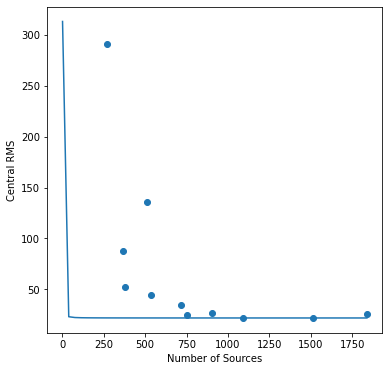

In [147]:
#N vs RMS
NperField = [714,1838,510,533,271,1093,366,1512,904,379,754]
CentralRMSs = [35,26,136,45,291,22,88,22,27,52,25]

fig = plt.figure(figsize=(6,6))
ax=plt.gca()
plt.scatter(NperField,CentralRMSs)
ax.set(xlabel = 'Number of Sources', ylabel="Central RMS")
x=np.linspace(1,1838)
y=291*x**-1.5 + 22
ax.plot(x,y)
plt.show()